In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'
response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)


#### Experiment to decode
experiment = 'blobs'
stim_filterby = 'first'
has_gratings = False


dff_resptest-nstds_respthr-10.00


# Output dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Get metadata for experiment type

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,26
Lm,22
V1,18


# Exclude datasets without RFs

In [7]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,13
Lm,12
V1,11


# Drop duplicates and whatnot fovs

In [8]:
if experiment=='blobs':
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
else:
    g_str = 'gratingsonly'
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [9]:
print(filter_str)
for k, v in exp_dkeys.items():
    print('... %s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00
... V1: 8 datasets
... Lm: 8 datasets
... Li: 9 datasets


In [10]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00


# Load neural responses

In [11]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, responsive_thr, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [12]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[1]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

## Check that all datasets have same stim configs

In [13]:
SDF={}
for datakey in stim_datakeys:
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid, verbose=False)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

nonpos_params = [p for p in sdf.columns if p not in ['xpos', 'ypos', 'position']] 
assert all([all(sdf[nonpos_params]==d[nonpos_params]) for k, d in SDF.items()]), "Incorrect stimuli..."

# Get screen and stimulus info

In [14]:
screeninfo = putils.get_screen_dims() #aggr.get_aggregate_stimulation_info(curr_sdata) #, experiment='blobs')
screenright = float(screeninfo['azimuth_deg']/2)
screenleft = -1*screenright #float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['altitude_deg']/2)
screenbottom = -1*screentop
screenaspect = float(screeninfo['resolution'][0]) / float(screeninfo['resolution'][1])
screeninfo

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Load RF fits

In [15]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [16]:
#### Load RF fits -------------------------------------
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05
# -----------------------------------------------------
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)

# Get position info for RFs 
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
df_fpath =  os.path.join(aggr_rf_dir, 
                            'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
rfdf = dutils.get_rf_positions(rf_dsets, df_fpath)

N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
Loading existing RF coord conversions...


# Select RFs

In [17]:
# Select RFs, whichever (rfs/rfs10) in common with blob rids
RFs = dutils.pick_rfs_with_most_overlap(rfdf, MEANS)

print("All RFs-----------------------------------")
pp.pprint(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("RFs with blobs -----------------------------------")
pp.pprint(RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


20190613_JC097_fov1: Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
20190622_JC085_fov1: Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
20190618_JC097_fov1: Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
20190602_JC091_fov1: Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
20190616_JC097_fov1: Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
20191006_JC110_fov1: Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)
All RFs-----------------------------------
             datakey
visual_area         
Li                24
Lm                21
V1                16
RFs with blobs -----------------------------------
             datakey
visual_area         
Li                13
Lm                12
V1                11


# Plot

<IPython.core.display.Javascript object>


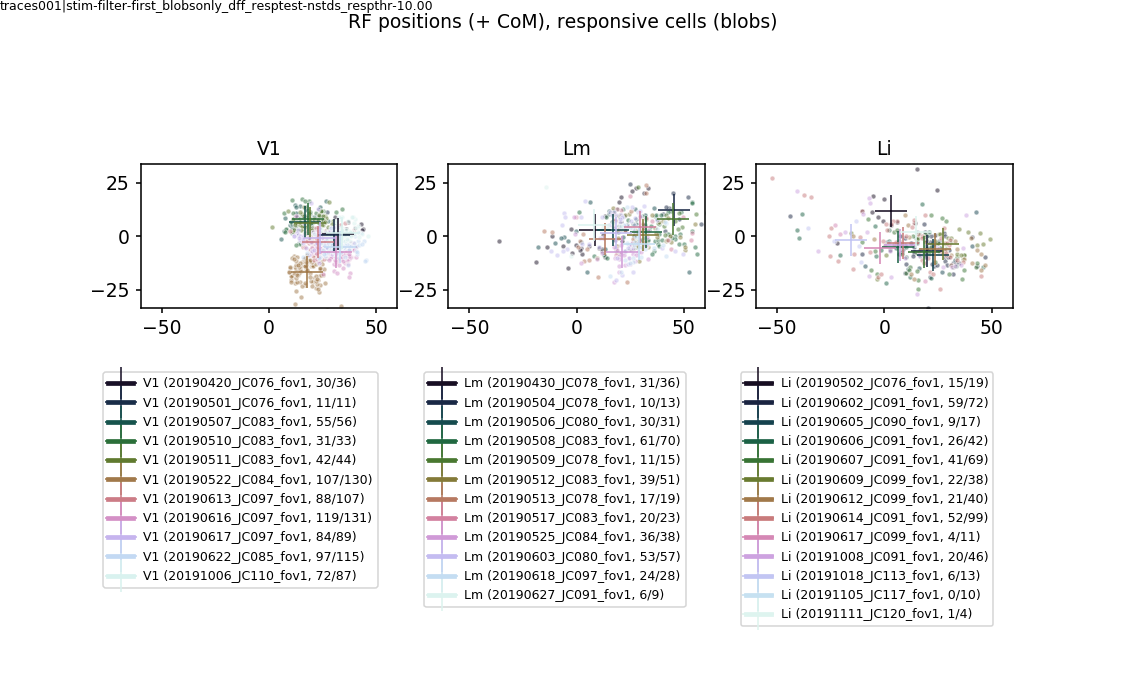

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff', 'CoM_label-fovs_common_to_blobs_and_rfs')


In [18]:
# Plot
fig = dutils.plot_all_rfs(RFs, MEANS, screeninfo, cmap='cubehelix')
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % experiment)
putils.label_figure(fig, data_id)
figname = 'CoM_label-fovs_common_to_blobs_and_rfs'
pl.savefig(os.path.join(aggr_rf_dir, '%s.svg' % figname))
print(aggr_rf_dir, figname)

# Calculate overlap with stimulus

#### Test with example FOV

In [19]:
experiment = 'blobs'

# TEST
animalid = 'JC110'
session = '20191006'
fovnum = 1

datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

20191006_JC110_fov1
Stimuli presented at coords: (30, 0)


In [36]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

g = RFs[RFs['datakey']==datakey].copy()

# Convert RF fit params to polygon
g.index = g['cell'].values
rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
# Concatenate into dataframe
perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})

In [36]:
perc_overlap

,area_overlap,stim_size,perc_overlap,cell
0,100.000000,10,1.000000,4.0
0,100.000000,10,1.000000,5.0
0,100.000000,10,1.000000,6.0
0,100.000000,10,1.000000,11.0
0,100.000000,10,1.000000,12.0
0,100.000000,10,1.000000,18.0
0,100.000000,10,1.000000,19.0
0,100.000000,10,1.000000,23.0
0,100.000000,10,1.000000,27.0
0,100.000000,10,1.000000,29.0


<IPython.core.display.Javascript object>


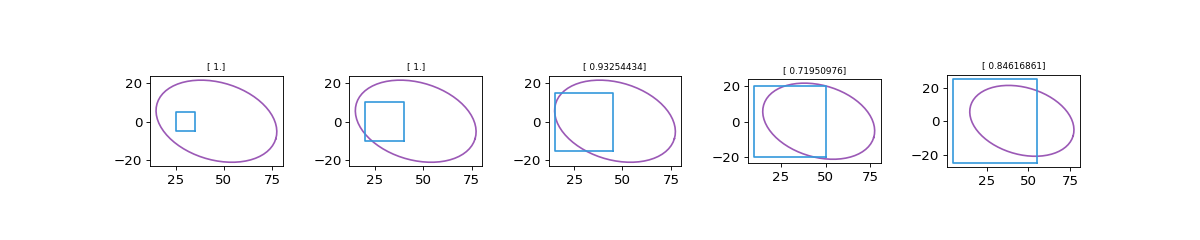

(0, array([ 1.]))
(1, array([ 1.]))
(2, array([ 0.93254434]))
(3, array([ 0.71950976]))
(4, array([ 0.84616861]))


In [69]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    #perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (stim_ix, p_stim))
    perc_overlap = rfutils.get_proportion_overlap(rf_poly, p_stim) 
    
    #print(perc_overlap)rfutils.get_proportion_overlap(rf_poly, stim_poly)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    ax.set_title(perc_overlap['perc_overlap'].values, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim[1].exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
    
pl.subplots_adjust(wspace=0.5)

In [67]:
perc_overlap

,area_overlap,col,perc_overlap,row
0,1273.943458,50,0.846169,384.0


# For all RFs measured, calculate overlap with stimuli

In [20]:
#### Calculate overlap with stimulus
stim_overlaps = dutils.calculate_overlaps(RFs, MEANS.keys(), experiment=experiment)


Stimuli presented at coords: (-5, 8)
Stimuli presented at coords: (15, 0)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -5)
Stimuli presented at coords: (10, -5)
---> (warning): no anatomicals for (JC091|20191008|FOV1_zoom2p0x)
Stimuli presented at coords: (20, -10)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (25, -5)
Stimuli presented at coords: (-15, 0)
Stimuli presented at coords: (0, 5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190509|FOV1_zoom2p0x)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190513|FOV1_zoom2p0x)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (15, 8)
Stimuli presented at coords: (15, 8)
---> (warning): no anatomicals for (JC083|20190508|FOV1_zoom2p0x)
Stimuli presented at co

<IPython.core.display.Javascript object>


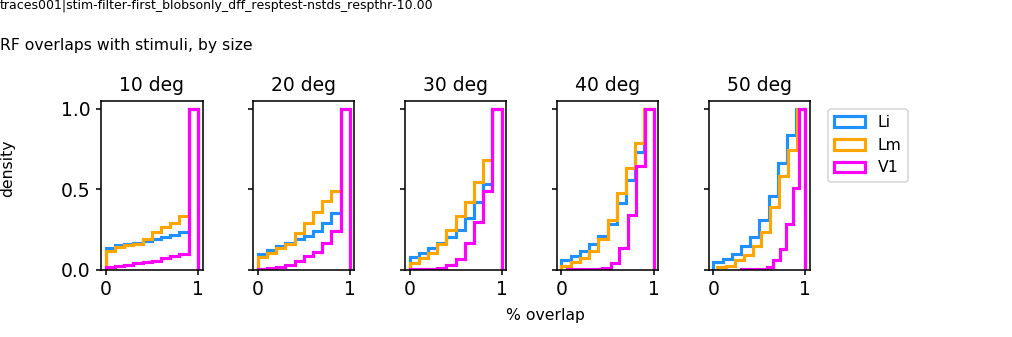

Text(0,0.85,u'RF overlaps with stimuli, by size')

In [22]:
# sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
#            kind='kdeplot', palette=area_colors, order=visual_areas)

fig, axn = pl.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True, dpi=dpi)
for ax, (sz, sg) in zip(axn.flat, stim_overlaps[['perc_overlap', 'visual_area', 'stim_size']].groupby(['stim_size'])):
    for v, vg in sg.groupby(['visual_area']):
        
        ax.hist(vg['perc_overlap'].values, color=area_colors[v], label=v,
                facecolor='none', edgecolor=area_colors[v], lw=2, alpha=1,
                density=True, cumulative=True, histtype='step')
    ax.set_title('%i deg' % (sz))
fig.text(0.5, 0.05, '% overlap')
fig.text(0.0, 0.5, 'density', rotation=90, va='center')

ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(wspace=0.5, top=0.7, right=0.8, bottom=0.2, left=0.1)

putils.label_figure(fig, data_id)
fig.text(0., 0.85, 'RF overlaps with stimuli, by size')

<IPython.core.display.Javascript object>


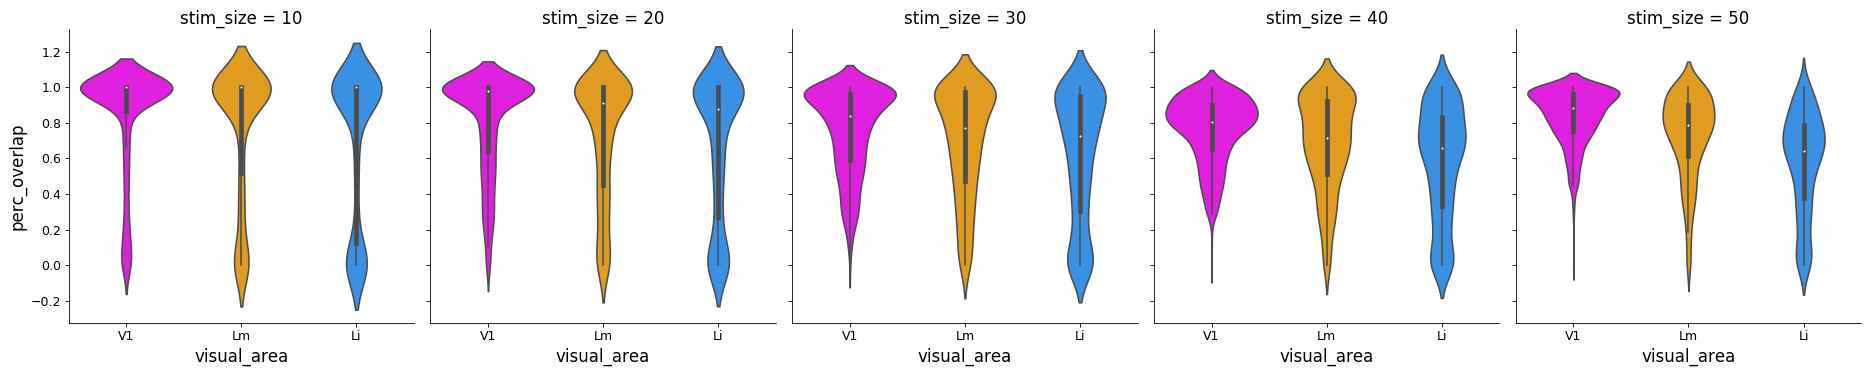

In [39]:
sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
           kind='violin', palette=area_colors, order=visual_areas)

# Get data common to RFs + blobs

In [21]:
# Get data common to RFs + blobs
c_list=[]
d_list = []
i=0
for (visual_area, datakey, rfname), g in stim_overlaps.groupby(['visual_area', 'datakey', 'rfname']):
    if datakey not in MEANS.keys():
        print("no %s: %s" % (experiment, datakey))
        continue

    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    rf_rids = sorted(g['cell'].unique())
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, (%s) %i common cells" % (visual_area, datakey, rfname, len(common_rids)))
    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i])) 
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    i+=1    
rfs_and_blobs = pd.concat(d_list, axis=0)   
common_counts = pd.concat(c_list, axis=0)

[Li] 20190502_JC076_fov1, (rfs) 15 common cells
[Li] 20190602_JC091_fov1, (rfs10) 59 common cells
[Li] 20190605_JC090_fov1, (rfs10) 9 common cells
[Li] 20190606_JC091_fov1, (rfs10) 26 common cells
[Li] 20190607_JC091_fov1, (rfs10) 41 common cells
[Li] 20190609_JC099_fov1, (rfs10) 22 common cells
[Li] 20190612_JC099_fov1, (rfs10) 21 common cells
[Li] 20190614_JC091_fov1, (rfs10) 52 common cells
[Li] 20190617_JC099_fov1, (rfs10) 4 common cells
[Li] 20191008_JC091_fov1, (rfs10) 20 common cells
[Li] 20191018_JC113_fov1, (rfs10) 6 common cells
[Li] 20191105_JC117_fov1, (rfs10) 0 common cells
[Li] 20191111_JC120_fov1, (rfs10) 1 common cells
[Lm] 20190430_JC078_fov1, (rfs) 31 common cells
[Lm] 20190504_JC078_fov1, (rfs) 10 common cells
[Lm] 20190506_JC080_fov1, (rfs) 30 common cells
[Lm] 20190508_JC083_fov1, (rfs) 61 common cells
[Lm] 20190509_JC078_fov1, (rfs) 11 common cells
[Lm] 20190512_JC083_fov1, (rfs) 39 common cells
[Lm] 20190513_JC078_fov1, (rfs) 17 common cells
[Lm] 20190517_JC083_f

In [19]:
common_counts.groupby(['visual_area']).count()

,datakey,n_cells,rfname
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


In [22]:
overlap_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

for overlap_thr in overlap_thr_values:
    pdf = rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].copy()
    print("Thr: %.2f --------------" % overlap_thr)
    print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

Thr: 0.00 --------------
             datakey  cell
visual_area               
Li               276   276
Lm               338   338
V1               736   736
Thr: 0.20 --------------
             datakey  cell
visual_area               
Li               264   264
Lm               337   337
V1               736   736
Thr: 0.40 --------------
             datakey  cell
visual_area               
Li               254   254
Lm               322   322
V1               736   736
Thr: 0.60 --------------
             datakey  cell
visual_area               
Li               248   248
Lm               302   302
V1               736   736
Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               241   241
Lm               272   272
V1               734   734
Thr: 1.00 --------------
             datakey  cell
visual_area               
Li               217   217
Lm               210   210
V1               664   664


# Set output dir

In [26]:
overlap_dir = os.path.join(decoding_dir, 'train-anchors')
if not os.path.exists(overlap_dir):
    os.makedirs(overlap_dir)
print(overlap_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors


# Linear separability, by RF overlap

In [27]:
import scipy.stats as spstats
import sklearn.metrics as skmetrics
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
# from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm


In [28]:
import multiprocessing as mp
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    pool.join()

def initializer(terminating_):
    # This places terminating in the global namespace of the worker subprocesses.
    # This allows the worker function to access `terminating` even though it is
    # not passed as an argument to the function.
    global terminating
    terminating = terminating_


def pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, n_iterations=50, n_processes=1,
                   test=None, single=False, n_train_configs=4):   
    '''
    test (string, None)
        None  : Classify A/B only (single=True to train/test on each size)
        morph : Train on anchors, test on intermediate morphs (single=True to train/test on each size)
        size  : Train on specific size(s), test on un-trained sizes (single=True to train/test on each size)
    '''
    
    results = []
    terminating = mp.Event()

    pool = mp.Pool(initializer=initializer, initargs=(terminating, ), processes=n_processes)  
    try:
        print("... n: %i (%i procs)" % (sample_ncells, n_processes))
        if test=='morph':
            if single: # train on 1 size, test on other sizes
                func = partial(dutils.do_fit_train_single_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else: # combine data across sizes
                func = partial(dutils.do_fit_train_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)             
        elif test=='size':
            if single:
                func = partial(dutils.do_fit_train_test_single, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else:
                func = partial(dutils.cycle_train_sets, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells, n_train_configs=n_train_configs)
        else:
            func = partial(dutils.do_fit, global_rois=global_rois, MEANS=MEANS, 
                           sdf=sdf, sample_ncells=sample_ncells)
        results = pool.map_async(func, range(n_iterations)).get(99999999)
        pool.close()
        pool.join()
    except KeyboardInterrupt:
        print("**interupt")
        pool.terminate()
        print("***Terminating!")
    finally:
        pool.close()
        pool.join()

    return results

In [30]:

def do_fit_train_single_test_morph_FOV(iter_num, curr_data, sdf=None,
                               cv=True, C_value=None, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106):
    '''
    Resample w/ replacement from pooled cells (across datasets). Assumes 'sdf' is same for all datasets.
    Return fit results for 1 iteration.
    Classes (class_a, class_b) should be the actual labels of the target (i.e., value of morph level)
    '''
    # Get new sample set
    #curr_data = dutils.get_trials_for_N_cells(sample_ncells, global_rois, MEANS)

    #### Select train/test configs for clf A vs B
    class_types = [class_a, class_b]
    restrict_transform = True
    class_name='morphlevel'
    constant_transform = 'size'
    sizes = sorted(sdf[constant_transform].unique())
    
    i_list=[]
    i=0
    # Go thru all training sizes, then test on non-trained sizes
    for train_transform in sizes:

        # Get train configs -- ANCHORS (A/B)
        train_configs = sdf[(sdf[class_name].isin(class_types))
                           & (sdf[constant_transform]==train_transform)].index.tolist()

        #### TRAIN SET --------------------------------------------------------------------
        # Get trial data for selected cells and config types
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        trainset = curr_data[curr_data['config'].isin(train_configs)].copy()
        train_data = trainset.drop('config', 1)#zdata = (data - data.mean()) / data.std()

        # Get labels
        targets = pd.DataFrame(trainset['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        #### TEST SET --------------------------------------------------------------------
        # Get data, specify configs
        novel_class_types = [c for c in sdf[class_name].unique() if c not in class_types]
        test_configs = sdf[(sdf[class_name].isin(novel_class_types))
                          & (sdf[constant_transform]==train_transform)].index.tolist()
        
        testset = curr_data[curr_data['config'].isin(test_configs)]
        test_data = testset.drop('config', 1) #zdata = (data - data.mean()) / data.std()

        # Get labels.
        test_targets = pd.DataFrame(testset['config'].copy(), columns=['config'])
        test_targets['label'] = [sdf['morphlevel'][cfg] for cfg in test_targets['config'].values]
        test_targets['group'] = [sdf['size'][cfg] for cfg in test_targets['config'].values]

        #### Train SVM ----------------------------------------------------------------------
        iterdict, trained_svc, trained_scaler, (predicted_labels, true_labels) = dutils.fit_svm(train_data, targets, 
                                                            return_clf=True, return_predictions=True,
                                                            test_split=test_size, cv_nfolds=cv_nfolds, 
                                                            cv=cv, C_value=C_value)
        for anchor in [class_a, class_b]:
            a_ixs = np.array([i for i, v in enumerate(true_labels) if v==anchor])
            p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels[a_ixs]])/float(len(predicted_labels[a_ixs]))
            iterdict.update({'p_chooseB': p_chooseB, 
                             '%s' % class_name: anchor, 
                             '%s' % constant_transform: train_transform})
            i_list.append(pd.DataFrame(iterdict, index=[i]))
            i+=1

        #### Test SVM
        for test_transform, curr_test_group in test_targets.groupby(['label']):
            curr_test_data = test_data.loc[curr_test_group.index].copy()
            curr_test_data = trained_scaler.transform(curr_test_data)

            #### Calculate p choose B on trials where morph X shown (test_transform)
            predicted_labels = trained_svc.predict(curr_test_data)
            p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels])/float(len(predicted_labels))

            iterdict.update({'p_chooseB': p_chooseB, 
                             '%s' % class_name: test_transform,
                             '%s' % constant_transform: train_transform})
            
            i_list.append(pd.DataFrame(iterdict, index=[i]))
            i+=1 
            
    iterdf = pd.concat(i_list, axis=0).reset_index(drop=True)
    iterdf['iteration'] = [iter_num for _ in np.arange(0, len(iterdf))]
    
    return iterdf

In [32]:
iter_num = 0
i_list=[]
for (visual_area, datakey), g in rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):
    #print(visual_area, datakey)
    if datakey not in stim_datakeys:
        print("%s unfound" % datakey)
        
    pass_rois = g['cell'].unique()
    
    ncells_total=MEANS[datakey].shape[1]-1
    curr_data = MEANS[datakey][pass_rois].copy()
    curr_data['config'] = MEANS[datakey]['config'].values
    
    print("%s | %s (%i of %i cells)" % (visual_area, datakey, len(pass_rois), ncells_total))
    
    iterdf = do_fit_train_single_test_morph_FOV(iter_num, curr_data, sdf=sdf, 
                                   cv=True, C_value=None, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)
    metainfo = {'visual_area': visual_area, 'datakey': datakey, 'n_cells': len(pass_rois)}
    
    iterdf = putils.add_meta_to_df(iterdf, metainfo)
    i_list.append(iterdf)

    iter_num += 1
df = pd.concat(i_list, axis=0)
print(i_list[0].shape, df.shape)


Li | 20190502_JC076_fov1 (11 of 150 cells)
Li | 20190602_JC091_fov1 (55 of 241 cells)
Li | 20190605_JC090_fov1 (5 of 129 cells)
Li | 20190606_JC091_fov1 (19 of 136 cells)
20190607_JC091_fov1 unfound
Li | 20190607_JC091_fov1 (33 of 260 cells)
Li | 20190609_JC099_fov1 (20 of 78 cells)
20190612_JC099_fov1 unfound
Li | 20190612_JC099_fov1 (15 of 95 cells)
20190614_JC091_fov1 unfound
Li | 20190614_JC091_fov1 (41 of 193 cells)
Li | 20190617_JC099_fov1 (1 of 25 cells)
20191008_JC091_fov1 unfound
Li | 20191008_JC091_fov1 (11 of 163 cells)
Li | 20191018_JC113_fov1 (5 of 64 cells)
Li | 20191111_JC120_fov1 (1 of 26 cells)
Lm | 20190430_JC078_fov1 (17 of 187 cells)
Lm | 20190504_JC078_fov1 (3 of 187 cells)
Lm | 20190506_JC080_fov1 (22 of 226 cells)
Lm | 20190508_JC083_fov1 (44 of 173 cells)
20190509_JC078_fov1 unfound
Lm | 20190509_JC078_fov1 (2 of 165 cells)
Lm | 20190512_JC083_fov1 (29 of 203 cells)
20190513_JC078_fov1 unfound
Lm | 20190513_JC078_fov1 (8 of 135 cells)
20190517_JC083_fov1 unfound

In [403]:
df.head()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,morphlevel,p_chooseB,score_time,size,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro,iteration,datakey,visual_area,n_cells
0,1.0,0.003066,0.093422,0.049242,0.13478,0.545455,0,0.000000,0.000943,10.0,0.588889,0.583333,0.583333,0.942857,0.942139,0.943333,99,20190502_JC076_fov1,Li,14
1,1.0,0.003066,0.093422,0.049242,0.13478,0.545455,106,0.444444,0.000943,10.0,0.588889,0.583333,0.583333,0.942857,0.942139,0.943333,99,20190502_JC076_fov1,Li,14
2,1.0,0.003066,0.093422,0.049242,0.13478,0.545455,-1,0.250000,0.000943,10.0,0.588889,0.583333,0.583333,0.942857,0.942139,0.943333,99,20190502_JC076_fov1,Li,14
3,1.0,0.003066,0.093422,0.049242,0.13478,0.545455,14,0.464286,0.000943,10.0,0.588889,0.583333,0.583333,0.942857,0.942139,0.943333,99,20190502_JC076_fov1,Li,14
4,1.0,0.003066,0.093422,0.049242,0.13478,0.545455,27,0.407407,0.000943,10.0,0.588889,0.583333,0.583333,0.942857,0.942139,0.943333,99,20190502_JC076_fov1,Li,14


In [36]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')

<IPython.core.display.Javascript object>


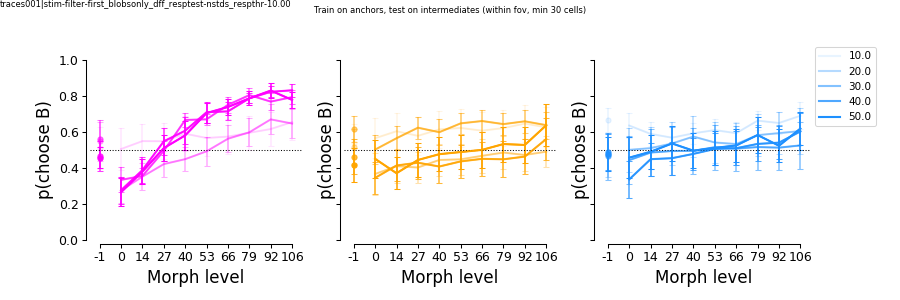

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors_by-FOV_split-size_min-30-cells_wLum')


In [45]:
min_ncells=30
lw=2

xdf = df[df['n_cells']>=min_ncells].copy()


fig, axn = pl.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
alphas = np.linspace(0.1, 1, 5)
ci = 95
shade=False
plot_ci=False
plot_luminance= True

plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

for visual_area, vdf in df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    for si, (sz, df_) in enumerate(vdf.groupby(['size'])):
        ax = dutils.plot_morph_curves(df_, sdf, col_name='morphlevel', 
                               plot_luminance=plot_luminance, plot_ci=plot_ci,
                               lw=lw, area_colors=area_colors, ax=ax, alpha=alphas[si], label=sz)
    if ai==2:
        ax.legend(bbox_to_anchor=(1, 1.1))   
        
    ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates (within fov, min %i cells)" % (min_ncells), fontsize=8)

putils.label_figure(fig, data_id)


figname = 'train-anchors_by-FOV_split-size_min-%i-cells_%s' % (min_ncells, plot_str)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

<IPython.core.display.Javascript object>


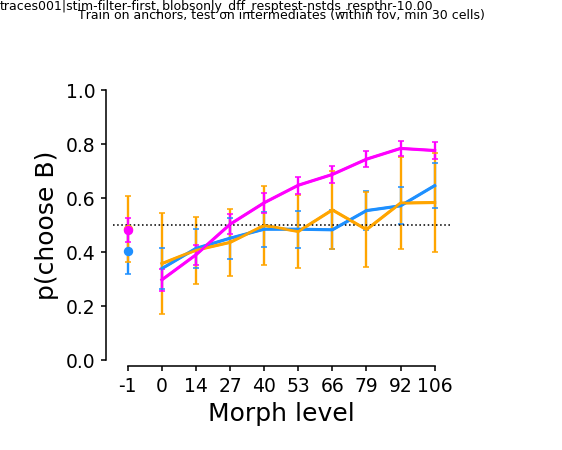

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors_by-FOV_min-30-cells_wLum')


In [46]:
ci=95
markersize=5
lw=2
capsize=2
plot_luminance=True
plot_ci=False
#shade=False
plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))
ax = plot_morph_curves(xdf, sdf, col_name='morphlevel', ci=ci, plot_luminance=plot_luminance, 
                      lw=lw, capsize=capsize, markersize=markersize, plot_ci=plot_ci,
                       area_colors=area_colors, ax=ax, dpi=dpi)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates (within fov, min %i cells)" % (min_ncells), fontsize=8)

putils.label_figure(fig, data_id)

figname = 'train-anchors_by-FOV_min-%i-cells_%s' % (min_ncells, plot_str)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [407]:
xdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    10
Lm     7
Li     5
Name: visual_area, dtype: int64

#### Test space

In [120]:
iter_num=0
sample_ncells=200
global_rois = filt_globaldf[filt_globaldf['visual_area']=='V1']
iterdf = do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                 sample_ncells=sample_ncells,
                                 cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)


In [123]:
iterdf.groupby(['size', 'morphlevel']).mean()['p_chooseB']

size  morphlevel
10.0  -1            0.206897
       0            0.600000
       14           0.379310
       27           0.517241
       40           0.620690
       53           0.517241
       66           0.517241
       79           0.586207
       92           0.482759
       106          0.857143
20.0  -1            0.965517
       0            0.125000
       14           0.379310
       27           0.620690
       40           0.586207
       53           0.793103
       66           0.793103
       79           0.758621
       92           0.862069
       106          0.750000
30.0  -1            0.586207
       0            0.375000
       14           0.379310
       27           0.586207
       40           0.724138
       53           0.724138
       66           0.655172
       79           0.758621
       92           0.862069
       106          0.750000
40.0  -1            0.517241
       0            0.166667
       14           0.379310
       27           0.5517

# Set decoding params

In [47]:
test_size=0.2
cv_nfolds=5
cv=True

class_a=0
class_b=106
class_name='morphlevel'
constant_transform='size'

# Pool cells

In [48]:
not_in_means = [r for r in MEANS.keys() if r not in stim_datakeys] # all blobs
not_in_rfs = [r for r in rfs_and_blobs['datakey'].unique() if r not in stim_datakeys] # all blobs w/ RFs (kinda)
print(len(not_in_rfs), len(not_in_means))

(11, 12)


In [103]:
overlap_thr=0.8
filter_fovs = True
remove_too_few = False
min_ncells = 20 if remove_too_few else 0

# ------------------------------------------------------------------------------------
filter_str = 'filter-repeat-fovs' if filter_fovs else 'all-fovs'
filter_str = '%s_%s' % (filter_str, 'remove-few') if remove_too_few else filter_str
print(filter_str)

pooled_cells, cell_counts = dutils.get_pooled_cells(stim_datakeys, rfs_and_blobs, 
                                             filter_fovs=filter_fovs, remove_too_few=remove_too_few, 
                                             overlap_thr=overlap_thr, min_ncells=min_ncells)

# Make sure have SAME N trials total
keys_with_min_reps = [k for k in stim_datakeys if MEANS[k]['config'].value_counts().min() < 29]
filt_globaldf = pooled_cells[~pooled_cells['datakey'].isin(keys_with_min_reps)]
print(filt_globaldf[~filt_globaldf['datakey'].isin(keys_with_min_reps)]['visual_area'].value_counts())


filter-repeat-fovs
('V1', 650)
('Lm', 201)
('Li', 127)
V1    650
Lm    201
Li    112
Name: visual_area, dtype: int64


In [104]:
print(cell_counts)
min(cell_counts.values())

{'V1': 650, 'Lm': 201, 'Li': 127}


127

# RFECV

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [52]:
n_iterations = 100
d_list = []
for n in np.arange(0, n_iterations):
    if n%20==0:
        print("...%i of %i" % (n, n_iterations))
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):
        total_ncells = min(cell_counts.values()) #cell_counts[visual_area]

        curr_data = dutils.get_trials_for_N_cells(total_ncells, global_rois, MEANS)
        train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(train_configs)].copy()
        x = sample_data.drop('config', 1)
        zdata = StandardScaler().fit_transform(x)

        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])   
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]   
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear", C=0.0001)

        # The "accuracy" scoring is proportional to the number of correct
        # classifications
        rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds, shuffle=True, random_state=10),
                      scoring='accuracy')
        rfecv.fit(zdata, targets['label'].values)

        d_list.append(pd.DataFrame({'score': rfecv.grid_scores_,
                                    'visual_area': [visual_area for _ in np.arange(0, total_ncells)],
                                    'iteration': [n for _ in np.arange(0, total_ncells)]}))
rfe_df = pd.concat(d_list, axis=0)


...0 of 100


KeyboardInterrupt: 

In [ ]:
fig, ax = pl.subplots()
for visual_area, df_ in rfe_df.groupby(['visual_area']):
    total_ncells = cell_counts[visual_area]
    
    mean_scores = df_.mean()['score']
    sem_scores = df_.sem()['scores']
    
    # Plot number of features VS. cross-validation scores
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), mean_scores, color=area_colors[visual_area], 
           lw=lw, label=visual_area)
    ax.fill_between(xvs, mean_scores-sem_scores, mean_scores+sem_scores, alpha=0.5, color=area_colors[visual_area])
    

ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score\n(# of correct classifications)")


In [197]:
rfecv.grid_scores_

(112,)

# Train on anchors, test on morphs (combine all sizes)

In [69]:

def plot_morph_curves(results, sdf, col_name='test_transform', plot_ci=False, ci=95, plot_luminance=True, lw=2, 
                      capsize=3, markersize=5, area_colors=None, ax=None, dpi=150, alpha=1, label=None):
    
    if area_colors is None:
        visual_areas, area_colors = putils.set_threecolor_palette()

    if ax is None:
        fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

    morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
    xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
    
    for visual_area, df_ in results.groupby(['visual_area']):
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = dutils.calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=area_colors[visual_area],
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, dutils.calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=area_colors[visual_area], lw=lw, alpha=alpha, label=label)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=area_colors[visual_area],
                          capsize=capsize, alpha=alpha, label=None)


        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    return ax


In [59]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [66]:
sample_ncells=112

train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)
res_outfile = os.path.join(dst_dir, '%s_results.pkl' % train_str)
print(res_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results.pkl


In [61]:

r_list=[]
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

#     iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
#                                test_generalization=True, single=False, n_train_configs=4,
#                                n_iterations=n_iterations, n_processes=n_processes)
#     iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)
        
    iter_list=[]
    for iter_num in np.arange(0,  n_iterations):
        if iter_num%20==0:
            print("... (%s) %i of %i" % (visual_area, iter_num, n_iterations))   
        tmpdf = dutils.do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                     sample_ncells=sample_ncells,
                                     cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)
        iter_list.append(tmpdf)
    iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

    add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
    iterdf = putils.add_meta_to_df(iterdf, add_info)

    r_list.append(iterdf)

results = pd.concat(r_list, axis=0).reset_index(drop=True)
print(r_list[0].shape, results.shape)



... (Li) 0 of 100
... (Li) 20 of 100
... (Li) 40 of 100
... (Li) 60 of 100
... (Li) 80 of 100
... (Lm) 0 of 100
... (Lm) 20 of 100
... (Lm) 40 of 100
... (Lm) 60 of 100
... (Lm) 80 of 100
... (V1) 0 of 100
... (V1) 20 of 100
... (V1) 40 of 100
... (V1) 60 of 100
... (V1) 80 of 100
((5000, 20), (15000, 20))


In [67]:
res_outfile = os.path.join(dst_dir, '%s_results2.pkl' % train_str)

# Save
print("Done!")
with open(res_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved to: %s" % res_outfile)


Done!
Saved to: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl


In [68]:
results.groupby(['visual_area', 'size', 'morphlevel']).mean()['p_chooseB']

visual_area  size  morphlevel
Li           10.0  -1            0.719655
                    0            0.329552
                    14           0.350690
                    27           0.397241
                    40           0.433793
                    53           0.374828
                    66           0.436897
                    79           0.633103
                    92           0.697931
                    106          0.601048
             20.0  -1            0.214483
                    0            0.298083
                    14           0.323793
                    27           0.371379
                    40           0.413103
                    53           0.366897
                    66           0.466897
                    79           0.580690
                    92           0.651724
                    106          0.623306
             30.0  -1            0.227931
                    0            0.239770
                    14           0.227586
    

In [98]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [99]:
train_str

'train-anchors-split-size_sample-112_iter-100'

<IPython.core.display.Javascript object>


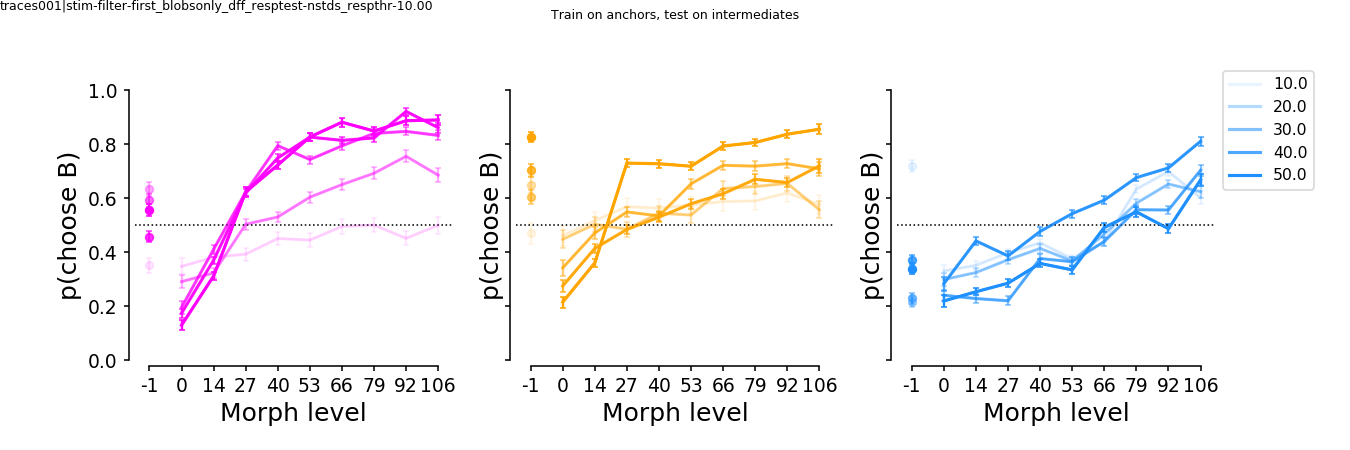

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_overlap-0.80_morphcurves_split-size__wLum')


In [100]:
dutils.default_morphcurves_split_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


<IPython.core.display.Javascript object>


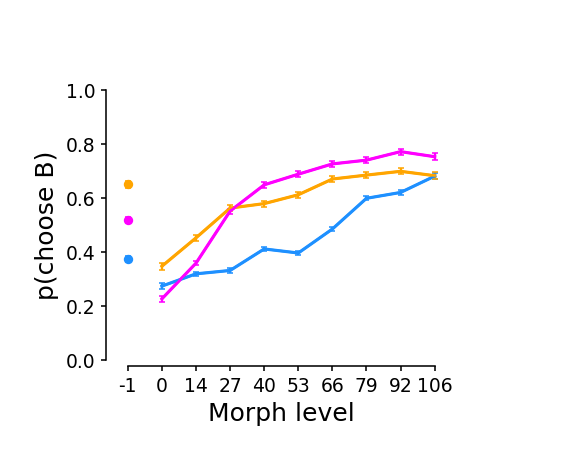

NameError: global name 'n_iterations' is not defined

In [101]:
dutils.default_morphcurves_avg_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


# Train on subset, test on 1

In [329]:
# def plot_scores_by_test_set(results, ax=None):
#     if ax is None:
#         fig, ax = pl.subplots(dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
#     sizes = [str(s) for s in sdf['size'].unique()]
#     markersize=5
#     for visual_area, vdf in results.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).sem()[metric]

#         ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=visual_area)
#         ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=None)

#         #ax.set_title(train_transform)
#         ax.axhline(y=0.5, color='k', linestyle=':')
#         ax.set_ylim([0.4, 1])
#         ax.set_xticks(np.arange(0, len(sizes)))
#         ax.set_xticklabels(sizes)

#     ax.set_xlabel('Test Size', fontsize=16)
#     ax.set_ylabel(metric, fontsize=16)
#     pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
#     sns.despine(trim=True, offset=4)
#     ax.legend(bbox_to_anchor=(1, 1.1))
#     return ax

In [330]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [331]:
n_train_configs=4
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

Results exist, loading...
False


### Load or do

In [332]:
n_processes=1
if do_fit:
    r_list=[]
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

        iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                                   test_generalization=True, single=False, n_train_configs=4,
                                   n_iterations=n_iterations, n_processes=n_processes)

        iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

        add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
        iterdf = putils.add_meta_to_df(iterdf, add_info)

        r_list.append(iterdf)

    results = pd.concat(r_list, axis=0).reset_index(drop=True)
    print(r_list[0].shape, results.shape)
    
    # Save
    print("Done!")
    with open(res_outfile, 'wb') as f:
        pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

    print("Saved to: %s" % res_outfile)


### plot

In [375]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


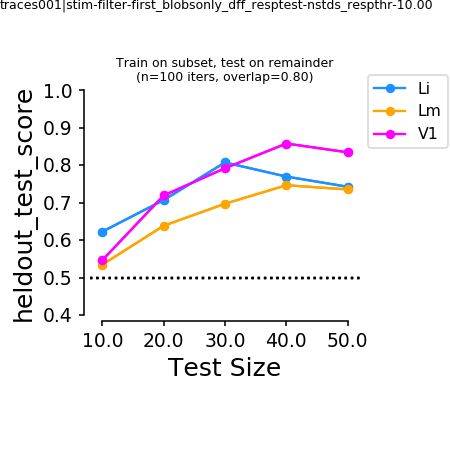

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


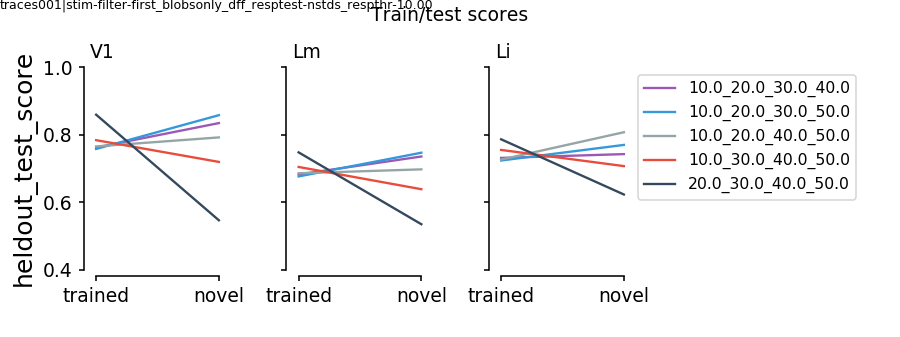

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


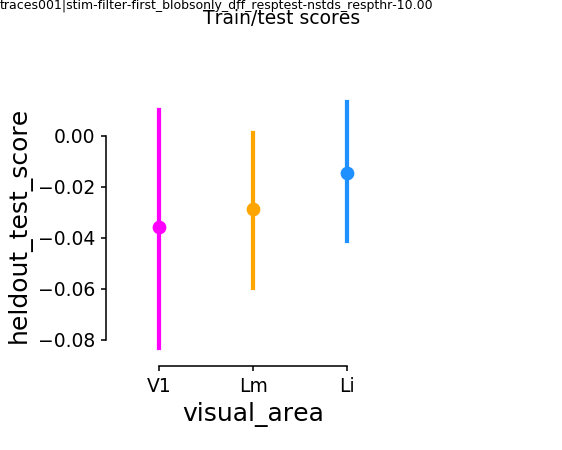

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [376]:


metric = 'heldout_test_score'
plot_str = '%s_%s_overlap-%.2f' % (train_str, metric, overlap_thr)
plot_title = "Train on subset, test on remainder\n(n=%i iters, overlap=%.2f)" % (n_iterations, overlap_thr)

dutils.default_train_test_subset(results, sdf, metric=metric, 
                                 plot_title=plot_title, plot_str=plot_str, dst_dir=overlap_dir, data_id=data_id)


# Test by N cells

In [ ]:
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

In [314]:
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in t_sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            rel_scores = (curr_test_vals/curr_train_vals) #* curr_train_vals
            
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
relative_df = pd.concat(r_list, axis=0).reset_index(drop=True) 

In [315]:
relative_means = relative_df.groupby(['visual_area', 'train_transform', 'test_transform']).mean().reset_index()



<IPython.core.display.Javascript object>


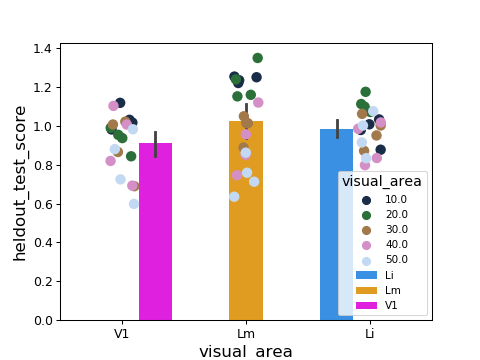

In [317]:
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, hue='train_transform', data=relative_means, ax=ax,
             order=visual_areas, palette='cubehelix', s=10)
sns.barplot(x='visual_area', y=metric, hue='visual_area', data=relative_means, ax=ax,
             order=visual_areas, palette=area_colors)

<IPython.core.display.Javascript object>


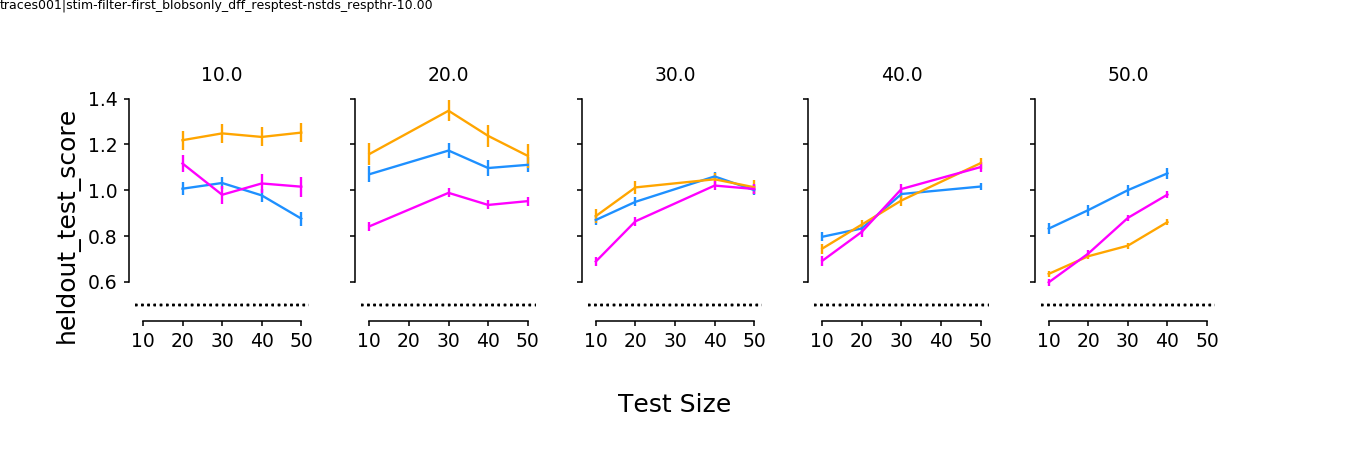

In [289]:
# Plot.

fig, axn = pl.subplots(1, 3, dpi=dpi, figsize=(12,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)

    mean_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).mean()[metric]
    sem_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).sem()[metric]

    
        currdf = traindf.groupby(['test_transform']).mean().reset_index()
        currdf_sem = traindf.groupby(['test_transform']).sem().reset_index()

        xv = sorted(currdf['test_transform'].values)
        yv = currdf.sort_values(by='test_transform')['%s' % metric].values
        yv_err = currdf_sem.sort_values(by='test_transform')['%s' % metric].values

        #train_index = xv.index(train_transform)

        ax.errorbar(xv, yv, yerr=yv_err, color=area_colors[visual_area])
#         ax.errorbar(xv[train_index], yv[train_index], yerr=yv_err[train_index], color=area_colors[visual_area],
#                    marker='o', markersize=10)

        ax.set_title(train_transform)
        ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(sizes)
        ax.set_xticklabels([int(s) for s in sizes])
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

# figname = 'generalize_size_%s__ncells-%i_overlap-%.2f_%i-iter' % (metric, sample_ncells, overlap_thr, n_iterations)
# pl.savefig(os.path.join(overlap_dir, '%s.svg' % figname))
# print(overlap_dir, figname)

In [61]:
rfs_and_blobs[(rfs_and_blobs['datakey'].isin(stim_datakeys)) 
             & (rfs_and_blobs['perc_overlap']>=overlap_thr)][['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

V1    650
Lm    201
Li    127
Name: visual_area, dtype: int64

# Test N cells

In [223]:
overlap_thr=0.8
filter_fovs = True
remove_too_few = False

m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
test_split=0.2
cv_nfolds=5
C_value=None
cv=True

# ------------------------------------------------------------------------------------
filter_str = 'filter-repeat-fovs' if filter_fovs else 'all-fovs'
filter_str = '%s_%s' % (filter_str, 'remove-few') if remove_too_few else filter_str
print(filter_str)

if filter_fovs:
    curr_dkeys = [s for s in stim_datakeys if s not in too_few] if remove_too_few else stim_datakeys
else:
    curr_dkeys = rfs_and_blobs['datakey'].unique()
    
globalcells_df, cell_counts = filter_rois(rfs_and_blobs[rfs_and_blobs['datakey'].isin(curr_dkeys)], 
                                                            overlap_thr=overlap_thr, return_counts=True)

# Make sure have SAME N trials total
keys_with_min_reps = [k for k, v in MEANS.items() if v['config'].value_counts().min() < 29]
print(globalcells_df[~globalcells_df['datakey'].isin(keys_with_min_reps)]['visual_area'].value_counts())
filt_globaldf = globalcells_df[~globalcells_df['datakey'].isin(keys_with_min_reps)]

filter-repeat-fovs
(25, 25)
V1    650
Lm    201
Li    127
Name: visual_area, dtype: int64


In [ ]:
if filter_fovs:
    print("... filtering")
    #NCELLS = [2, 4, 8, 16, 32, 64, 77, 128, 165, 256, 448, 610]
    NCELLS = [2, 4, 8, 16, 32, 64, 82, 102, 148, 186, 256, 448, 610]
else:
    print("... getting all the cells")
    #NCELLS = [2, 4, 8, 16, 32, 64, 128, 143, 206, 412, 524, 669]
    NCELLS = [2, 4, 8, 16, 32, 64, 128, 197, 261, 448, 556, 669]
    
print("NCELLS: %s" % (str(NCELLS)))
ncells_dict = dict((k, NCELLS) for k in overlap_thr_values)


In [161]:
# NCELLS = [2, 4, 8, 16, 32, 64, 82, 102, 148, 186, 256, 448, 610]
NCELLS = [2, 4, 8, 16, 32, 64, 86, 112, 148, 201, 300, 448, 650]

In [ ]:

# Set overlap amount
overlap_thr_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_thr_int, overlap_thr_int)


In [69]:
n_processes = 4
n_iterations=100

popdf = []
#popdf_chance = []
i = 0

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)

for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):
#gdf = filt_globaldf[filt_globaldf['visual_area']==visual_area].copy()

    for sample_ncells in NCELLS: #[0::2]:
        print("... [%s] popn size: %i" % (visual_area, sample_ncells))
        if sample_ncells > cell_counts[visual_area]:
            continue
            
        iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                                   n_iterations=n_iterations, n_processes=n_processes)

        # DATA - get mean across iters
        iter_results = pd.concat(iter_list, axis=0)
        iterd = dict(iter_results.mean())
        iterd.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results.std().index, iter_results.std().values)) )
        iterd.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results.sem().index, iter_results.sem().values)) )
        iterd.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})

        popdf.append(pd.DataFrame(iterd, index=[i]))
        #popdf_chance.append(pd.DataFrame(iterd_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
#pooled_chance = pd.concat(popdf_chance, axis=0)
#print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
... [Li] popn size: 2
... n: 2 (4 procs)
... [Li] popn size: 4
... n: 4 (4 procs)
... [Li] popn size: 8
... n: 8 (4 procs)
... [Li] popn size: 16
... n: 16 (4 procs)
... [Li] popn size: 32
... n: 32 (4 procs)


Process PoolWorker-19:
Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)


**interupt


  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/pool.py", line 113, in worker
    result = (True, func(*args, **kwds))
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/multiprocessing/pool.py", line 65, in mapstar
    return map(*args)
  File "<ipython-input-50-893419be914c>", line 10, in do_fit
    curr_data = get_trials_for_N_cells(sample_ncells, global_rois, MEANS)
  File "<ipython-input-46-68df4706bbb3>", line 52, in get_trials_for_N_cells
    cfg_df = cfg_df.T.drop_duplicates().T
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/pandas/core/frame.py", line 3098, in drop_duplicates
    duplicated = self.duplicated(subset, keep=keep)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/pandas/core/frame.py", line 3146, in duplicated
    ids = get_group_index(labels, shape, sort=False, xnull=False)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/pandas/core/sorting.py", line 94, i

***Terminating!


ValueError: No objects to concatenate

In [ ]:
lw=2
capsize=5
metric='heldout_test_score'
fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(pooled.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=1, lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)

# for ai, (visual_area, g) in enumerate(chance_df.groupby(['visual_area'])):
#     mean_scores = g.sort_values(by='n_units')[metric]
#     std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
#     n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
#     ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
#             alpha=1, lw=lw, linestyle=':', 
#             label=None)
#     ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
#                 capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
#                 lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)

zoom_str=''
if zoom:
    ax.set_xlim([0, 120])
    zoom_str = 'zoom'
    
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

putils.label_figure(fig, data_id)
figname = '%s_%s%s_crossval-C-by-ncells_%iv%i_overlap-thr=%.2f' % (filter_str, metric, zoom_str, m0, m106, overlap_thr)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname)

In [313]:
popdf = []
popdf_chance = []
i = 0

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)

# Get list of eligible cells from all FOVs
for visual_area, gdf in filt_globaldf.groupby(['visual_area']):
    for sample_ncells in NCELLS: #[0::2]:
        print("... [%s] popn size: %i" % (visual_area, sample_ncells))
        if sample_ncells > cell_counts[visual_area]:
            continue
        iterd, iterd_chance = resample_data_fit_classifier(gdf, MEANS, sdf, sample_ncells=sample_ncells,
                                                           C_value=C_value, test_size=test_split, cv_nfolds=cv_nfolds,
                                                           class_a=m0, class_b=m100, 
                                                           n_iterations=n_iterations)

        iterd.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})
        iterd_chance.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})

        popdf.append(pd.DataFrame(iterd, index=[i]))
        popdf_chance.append(pd.DataFrame(iterd_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
... [Li] popn size: 2
... [Li] popn size: 4
... [Li] popn size: 8
... [Li] popn size: 16
... [Li] popn size: 32
... [Li] popn size: 64
... [Li] popn size: 82
... [Li] popn size: 102
... [Li] popn size: 148
... [Li] popn size: 186
... [Li] popn size: 256
... [Li] popn size: 448
... [Li] popn size: 610
... [Lm] popn size: 2
... [Lm] popn size: 4
... [Lm] popn size: 8
... [Lm] popn size: 16
... [Lm] popn size: 32
... [Lm] popn size: 64
... [Lm] popn size: 82
... [Lm] popn size: 102
... [Lm] popn size: 148
... [Lm] popn size: 186
... [Lm] popn size: 256
... [Lm] popn size: 448
... [Lm] popn size: 610
... [V1] popn size: 2
... [V1] popn size: 4
... [V1] popn size: 8
... [V1] popn size: 16
... [V1] popn size: 32
... [V1] popn size: 64
... [V1] popn size: 82
... [V1] popn size: 102
... [V1] popn size: 148
... [V1] popn size: 186
... [V1] popn size: 256
... [V1] popn size: 448
... [V1] popn size: 610
((31, 39), (31, 39))


,fit_time,fit_time_sem,fit_time_std,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,...,train_accuracy,train_accuracy_sem,train_accuracy_std,train_neg_mean_squared_error,train_neg_mean_squared_error_sem,train_neg_mean_squared_error_std,train_r2,train_r2_sem,train_r2_std,visual_area
0,0.008256,0.000025,0.000253,0.012733,0.002021,0.020214,0.007258,0.002872,0.028724,0.018370,...,0.523601,0.003444,0.034440,-5352.823309,38.696644,386.966438,-0.907139,0.013803,0.138028,Li
1,0.008552,0.000023,0.000232,0.014421,0.002290,0.022896,0.008191,0.003396,0.033956,0.020805,...,0.535539,0.003376,0.033759,-5218.680408,37.931839,379.318387,-0.859211,0.013499,0.134990,Li
2,0.009405,0.000057,0.000572,0.021756,0.002912,0.029115,0.018923,0.004302,0.043019,0.031387,...,0.573207,0.004190,0.041899,-4795.443025,47.077679,470.776792,-0.708283,0.016729,0.167287,Li
3,0.013747,0.000111,0.001111,0.027711,0.003500,0.035002,0.027662,0.005147,0.051475,0.039978,...,0.614939,0.004112,0.041118,-4326.542887,46.199963,461.999625,-0.541617,0.016478,0.164778,Li
4,0.018535,0.000415,0.004150,0.051287,0.004501,0.045012,0.062212,0.006605,0.066045,0.073991,...,0.700284,0.003792,0.037924,-3367.606197,42.611536,426.115361,-0.199629,0.015184,0.151839,Li


<IPython.core.display.Javascript object>


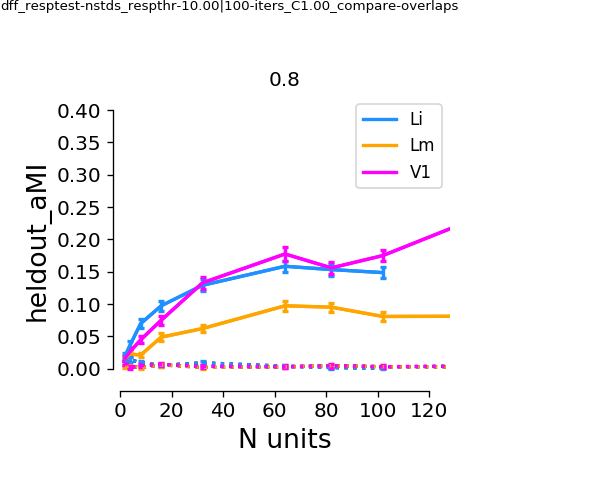

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_aMI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


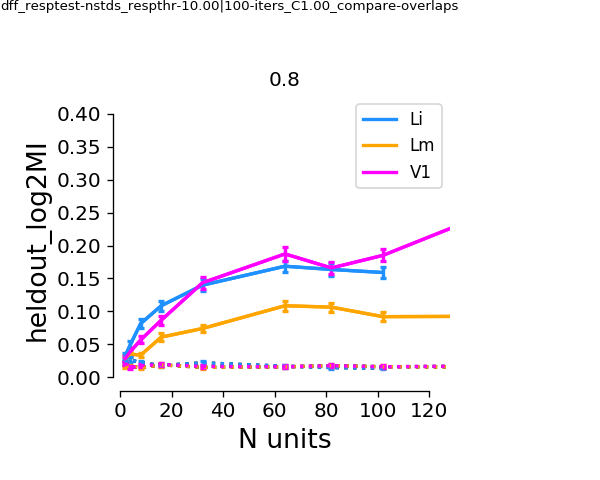

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_log2MI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


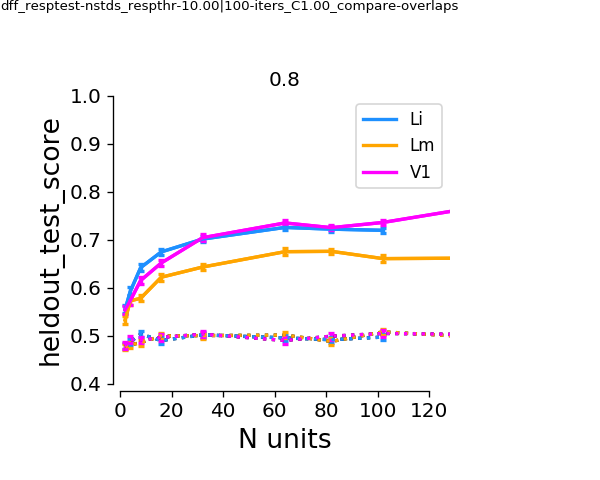

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_test_score_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


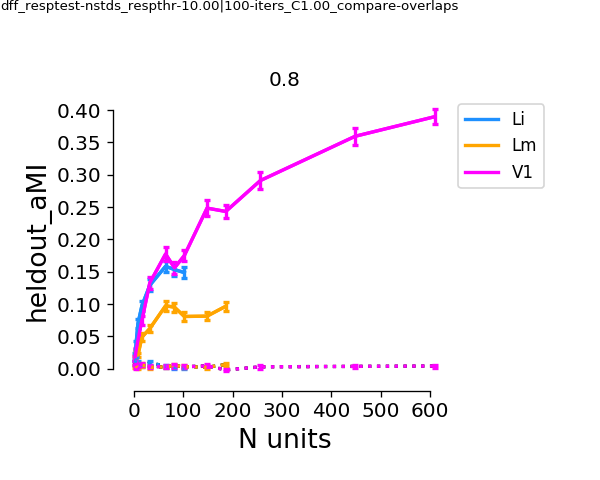

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_aMI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


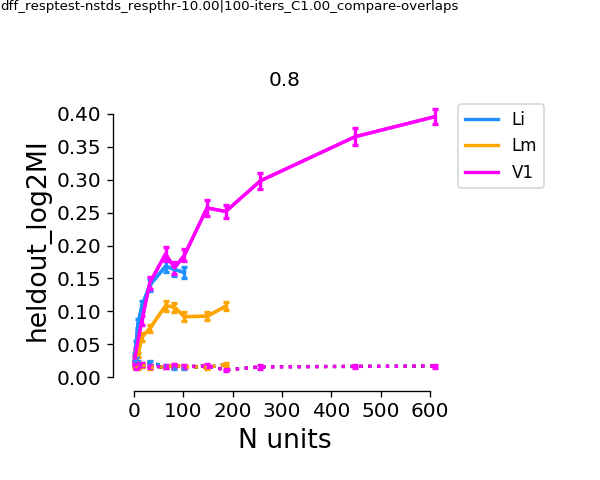

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_log2MI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


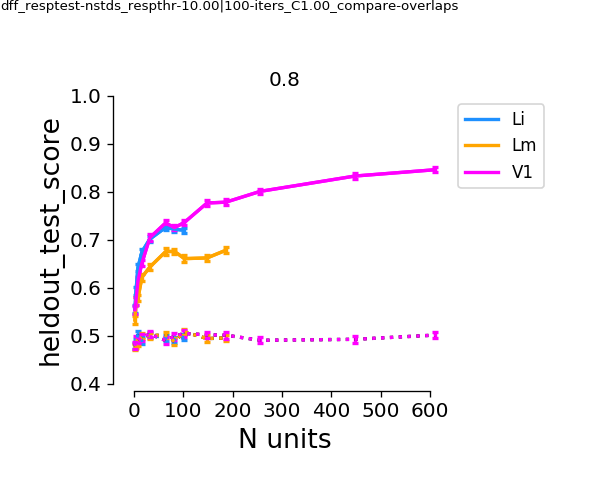

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_test_score_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


In [289]:
#zoom=True

#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
overlap_thr=0.8

res_df = pooled.copy() #pooled[pooled['overlap_thr']==overlap_thr].copy()
chance_df = pooled_chance.copy() #[pooled_chance['overlap_thr']==overlap_thr].copy()

lw = 2
capsize=2

for zoom in [True, False]:
    for metric in ['heldout_aMI', 'heldout_log2MI', 'heldout_test_score']:
        metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
        
        fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
        for ai, (visual_area, g) in enumerate(res_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                    alpha=1, lw=lw,
                    label='%s' % (visual_area))
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw)
        ax.legend(bbox_to_anchor=(1., 1))
        ax.set_title(overlap_thr)
        ax.set_xlabel("N units")
        ax.set_ylabel(metric)

        for ai, (visual_area, g) in enumerate(chance_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                    alpha=1, lw=lw, linestyle=':', 
                    label=None)
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw, linestyle=':')
        if metric=='heldout_test_score':
            ax.set_ylim([0.4, 1.0])
        ax.set_ylabel(metric)

        if zoom:
            ax.set_xlim([0, 128])
            zoom_str = 'zoom_'
        else:
            zoom_str=''

        sns.despine(trim=True, offset=4)
        pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

        analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

        putils.label_figure(fig, analysis_str)

        figname = '_sameNtrials_%s_%s%s_overlap%.2f_%ivs%i_split-test-%.2f_%i-fold-cv_C%.2f_niter%i__%s' % (filter_str, zoom_str, metric, overlap_thr, m0, m100, test_split, cv_nfolds, C_value, n_iterations, response_str)
        pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

        print(decoding_dir, figname)

In [ ]:
response_str

In [233]:
screeninfo

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Cycle thru all visual areas

In [174]:
overlap_thr=0.8
    
popdf = []
popdf_chance = []
i = 0

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)

# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 
#globaldf = filter_rois(has_blobs, overlap_thr=overlap_thr) 


for curr_ncells in [20, 40, 80, 100]: #NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]
        iter_results_chance=[]
        for iteration in np.arange(0, n_iterations): #n_iterations):
            
            curr_data = get_trials_for_N_cells(curr_ncells, gdf, MEANS)

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
            targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]
            
            #### Fit
            curr_iter, curr_iter_chance = fit_svm(zdata, targets, C_value=1.0, test_split=0.2)
            iter_results.append(pd.DataFrame(curr_iter, index=[iteration]))
            iter_results_chance.append(pd.DataFrame(curr_iter_chance, index=[iteration]))

        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results.std().index, iter_results.std().values)) )
        iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results.sem().index, iter_results.sem().values)) )
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
        iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
{'V1': 572, 'Lm': 185, 'Li': 100}
... [Li] popn size: 20
... [Lm] popn size: 20
... [V1] popn size: 20
... [Li] popn size: 40
... [Lm] popn size: 40
... [V1] popn size: 40
... [Li] popn size: 80
... [Lm] popn size: 80
... [V1] popn size: 80
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100
((12, 39), (12, 39))


,fit_time,fit_time_sem,fit_time_std,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,...,train_accuracy,train_accuracy_sem,train_accuracy_std,train_neg_mean_squared_error,train_neg_mean_squared_error_sem,train_neg_mean_squared_error_std,train_r2,train_r2_sem,train_r2_std,visual_area
0,0.012825,0.000153,0.001526,0.084204,0.005645,0.056454,0.110287,0.008290,0.082901,0.121481,...,0.753935,0.003685,0.036850,-2764.786598,41.404411,414.044107,0.014907,0.014734,0.147337,Li
1,0.014310,0.000103,0.001032,0.049176,0.004341,0.043415,0.059080,0.006362,0.063624,0.070946,...,0.715883,0.003049,0.030495,-3192.343603,34.263902,342.639019,-0.137280,0.012193,0.121926,Lm
2,0.013875,0.000096,0.000958,0.067498,0.004451,0.044508,0.086056,0.006525,0.065246,0.097379,...,0.746677,0.003333,0.033330,-2846.336993,37.449029,374.490286,-0.014178,0.013338,0.133383,V1
3,0.013824,0.000180,0.001803,0.106442,0.005841,0.058411,0.142634,0.008603,0.086033,0.153563,...,0.827296,0.002714,0.027140,-1940.501668,30.494494,304.944938,0.308511,0.010876,0.108759,Li
4,0.017510,0.000138,0.001375,0.064833,0.004603,0.046032,0.082140,0.006764,0.067636,0.093534,...,0.794026,0.002396,0.023961,-2314.326118,26.922625,269.226252,0.175310,0.009589,0.095894,Lm


In [162]:
pooled_outfile = os.path.join(decoding_dir, 'results_overlap-%.2f.pkl' % overlap_thr)
with open(pooled_outfile, 'wb') as f:
    pkl.dump(pooled, f, protocol=pkl.HIGHEST_PROTOCOL)
    
chance_outfile = os.path.join(decoding_dir, 'shuffled_overlap-%.2f.pkl' % overlap_thr)
with open(chance_outfile, 'wb') as f:
    pkl.dump(pooled_chance, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [172]:
pooled.columns

Index([u'fit_time', u'fit_time_sem', u'fit_time_std', u'heldout_MI',
       u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_neg_mean_squared_error', u'test_neg_mean_squared_error_sem',
       u'test_neg_mean_squared_error_std', u'test_r2', u'test_r2_sem',
       u'test_r2_std', u'train_accuracy', u'train_accuracy_sem',
       u'train_accuracy_std', u'train_neg_mean_squared_error',
       u'train_neg_mean_squared_error_sem',
       u'train_neg_mean_squared_error_std', u'train_r2', u'train_r2_sem',
       u'train_r2_std', u'visual_area'],
      dtype='object')

<IPython.core.display.Javascript object>


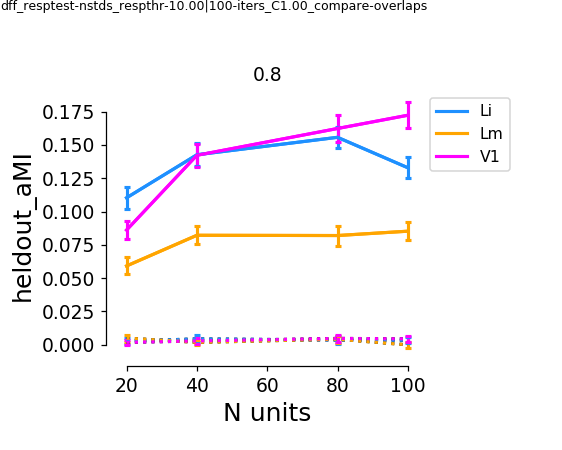

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'CoM_label-fovs_common_to_blobs_and_rfs')


In [175]:
#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'

metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(pooled.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=1, lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(pooled_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=1, lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

putils.label_figure(fig, analysis_str)
   
#figname = '%s_%ivs%i_split-test-%.2f_%i-fold-cv_overlap%.2f_C%.2f_niter%i__%s' % (metric, m0, m100, test_split, cv_nfolds, overlap_thr, C_value, n_iterations, response_str)
#pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

print(decoding_dir, figname)


# Get all overlaps, all iters

In [85]:
NCELLS

[4, 8, 16, 32, 64, 128, 168]

In [86]:
overlap_int=0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)
overlap_thr_values

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [87]:
ncells_dict = dict((k, NCELLS) for k in overlap_thr_values)
ncells_dict

{0.0: [4, 8, 16, 32, 64, 128, 168],
 0.20000000000000001: [4, 8, 16, 32, 64, 128, 168],
 0.40000000000000002: [4, 8, 16, 32, 64, 128, 168],
 0.60000000000000009: [4, 8, 16, 32, 64, 128, 168],
 0.80000000000000004: [4, 8, 16, 32, 64, 128, 168],
 1.0: [4, 8, 16, 32, 64, 128, 168]}

In [88]:
n_iterations

100

In [89]:
#if load_popdata:
    
popdf = []
popdf_chance = []
i = 0
for overlap_thr, NCELLS in ncells_dict.items():
    print("-------- Overlap: %.2f --------" % overlap_thr)
    # Get list of eligible cells from all FOVs
    globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


    for curr_ncells in NCELLS:
        for visual_area, gdf in globaldf.groupby(['visual_area']):
            print("... [%s] popn size: %i" % (visual_area, curr_ncells))

            iter_results=[]
            iter_results_chance=[]
            for iteration in np.arange(0, n_iterations): #n_iterations):

                curr_data = get_trials_for_N_cells(curr_ncells, gdf, MEANS)

                #### Select train/test configs for clf A vs B
                object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
                curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
                sample_data = curr_data[curr_data['config'].isin(object_configs)]

                #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
                data = sample_data[curr_roi_list]
                zdata = (data - data.mean()) / data.std()

                #### Get labels
                targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
                targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
                targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

                #### Fit
                curr_iter, curr_iter_chance = fit_svm(zdata, targets, C_value=1.0, test_split=0.2)
                iter_results.append(pd.DataFrame(curr_iter, index=[iteration]))
                iter_results_chance.append(pd.DataFrame(curr_iter_chance, index=[iteration]))

            # DATA - get mean across iters
            iter_results = pd.concat(iter_results, axis=0)
            iterdict = dict(iter_results.mean())
            iterdict.update( dict(('%s_std' % k, v) for k, v in \
                                  zip(iter_results.std().index, iter_results.std().values)) )
            iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                                  zip(iter_results.sem().index, iter_results.sem().values)) )
            iterdict.update({'n_units': curr_ncells, 
                             'overlap': overlap_thr,
                             'visual_area': visual_area})
            popdf.append(pd.DataFrame(iterdict, index=[i]))

            # CHANCE - get mean across iters
            iter_results_chance = pd.concat(iter_results_chance, axis=0)
            iterdict_chance = dict(iter_results_chance.mean())
            iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                                  zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
            iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                                  zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
            iterdict_chance.update({'n_units': curr_ncells, 
                                    'overlap': overlap_thr,
                                    'visual_area': visual_area})
            popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
            i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.00 --------
('V1', 652)
('Lm', 237)
('Li', 142)
{'V1': 652, 'Lm': 237, 'Li': 142}
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 128
... [Lm] popn size: 128
... [V1] popn size: 128
... [Li] popn size: 168
... [Lm] popn size: 168
... [V1] popn size: 168
-------- Overlap: 1.00 --------
('V1', 473)
('Lm', 155)
('Li', 89)
{'V1': 473, 'Lm': 155, 'Li': 89}
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64

,fit_time,fit_time_sem,fit_time_std,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,...,train_accuracy,train_accuracy_sem,train_accuracy_std,train_neg_mean_squared_error,train_neg_mean_squared_error_sem,train_neg_mean_squared_error_std,train_r2,train_r2_sem,train_r2_std,visual_area
0,0.004631,0.000146,0.001462,0.033441,0.003553,0.035533,0.034441,0.005263,0.052634,0.048245,...,0.616248,0.005384,0.053843,-4311.836682,60.497972,604.979716,-0.536624,0.021543,0.215431,Li
1,0.006269,0.000151,0.001513,0.021921,0.003462,0.034620,0.019172,0.005073,0.050735,0.031625,...,0.605438,0.004147,0.041474,-4433.302853,46.600598,466.005979,-0.579652,0.016599,0.165995,Lm
2,0.005198,0.000147,0.001474,0.028299,0.003141,0.031408,0.028716,0.004608,0.046081,0.040827,...,0.614874,0.003806,0.038059,-4327.276421,42.762860,427.628604,-0.542153,0.015284,0.152842,V1
3,0.006957,0.000170,0.001704,0.052132,0.004871,0.048708,0.062061,0.007204,0.072043,0.075210,...,0.667021,0.004869,0.048688,-3741.347000,54.706396,547.063964,-0.333138,0.019471,0.194715,Li
4,0.008349,0.000101,0.001010,0.033749,0.003508,0.035082,0.036490,0.005140,0.051398,0.048690,...,0.634245,0.003304,0.033044,-4109.621918,37.128067,371.280670,-0.464166,0.013217,0.132167,Lm


In [90]:
pooled_decoding_results = os.path.join(decoding_dir, 'pooled_%i-iter_%iv%i_stratified-folds_perc_overlap__%s.pkl' % (n_iterations, m0, m100, response_str))

with open(pooled_decoding_results, 'wb') as f:
    pkl.dump({'pooled': pooled, 'pooled_chance': pooled_chance}, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved results:\n--->%s" % pooled_decoding_results)

Saved results:
--->/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/pooled_100-iter_0v106_stratified-folds_perc_overlap__dff_resptest-nstds_respthr-10.00.pkl


## split by v area

<IPython.core.display.Javascript object>


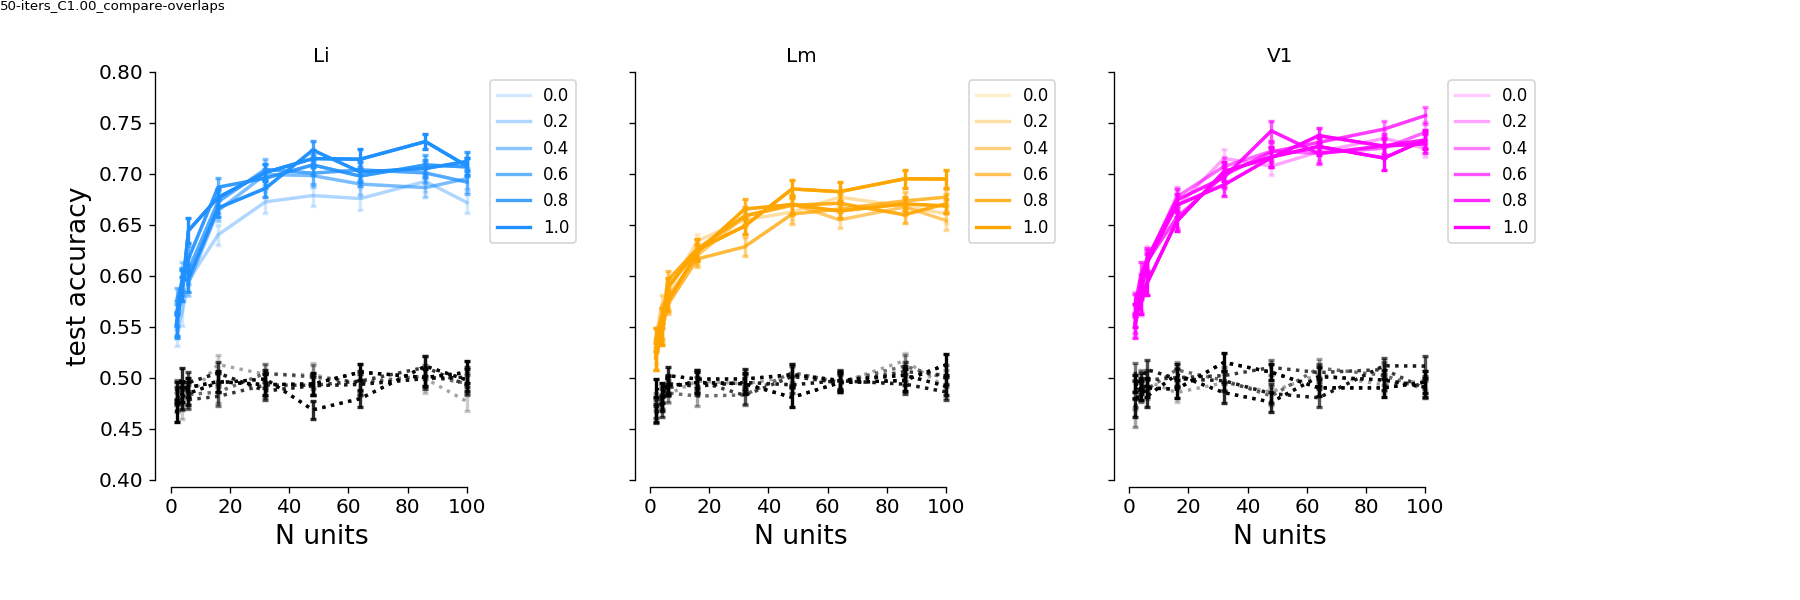

heldout_test_score_compare-overlaps_split-visual-area_C1.00_niter50__dff_resptest-nstds_respthr-0.05


In [1121]:
metric = 'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))

fig, axes = pl.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True, dpi=dpi)
ai = 0
for visual_area, pgroup in pooled.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%.1f' % (overlap_l))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw)
    if ai==0:
        ax.set_ylabel("test accuracy")
    
    ax.legend(bbox_to_anchor=(1.0, 1))
    ax.set_title(visual_area)
    ai += 1
    ax.set_xlabel("N units")

ai=0
for visual_area, pgroup in pooled_chance.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color='k', #area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
        
    ai += 1
    
ax.set_ylim([0.4, 0.8])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.8, left=0.09, wspace=0.5, bottom=0.2)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str) 

figname = '%s_compare-overlaps_split-visual-area_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

print(figname)

## Plot visual areas together, split by overlap_thr

<IPython.core.display.Javascript object>


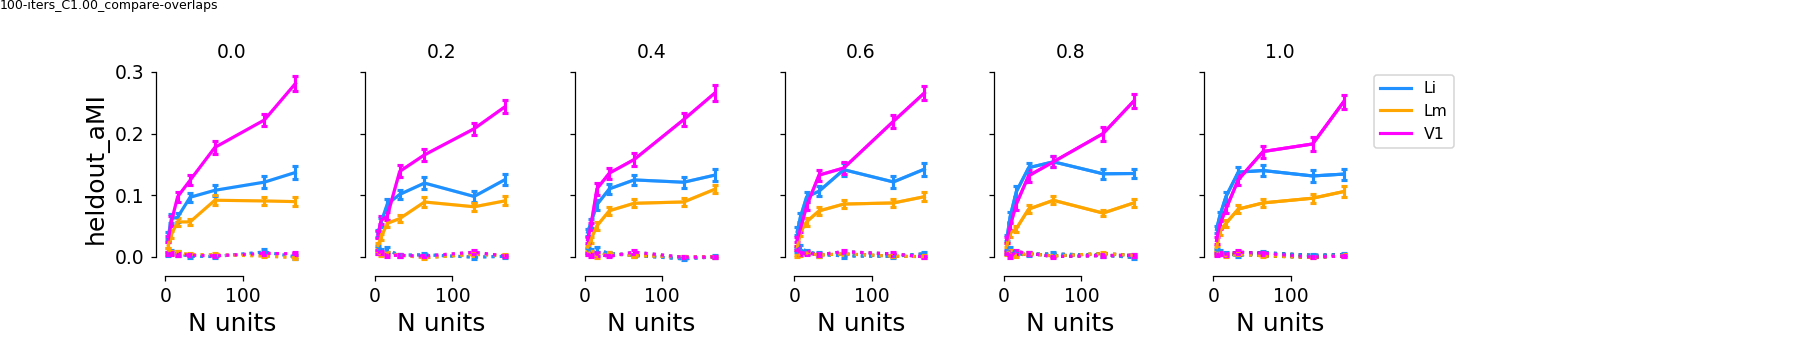

heldout_aMI_perc_overlap_statified-folds_C1.00_niter100__dff_resptest-nstds_respthr-10.00


In [91]:
metric = 'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))


fig, axn = pl.subplots(1, 6, figsize=(16,3), sharex=True, sharey=True, dpi=dpi)
for ci, (overlap_l, pgroup) in enumerate(pooled.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw)
    ax.set_ylabel('')
    if ci==5:
        ax.legend(bbox_to_anchor=(1.8, 1))
    ax.set_title(overlap_l)
    ax.set_xlabel("N units")
    ax.set_ylabel('classifier accuracy')

for ci, (overlap_l, pgroup) in enumerate(pooled_chance.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    if metric=='heldout_test_score':
        ax.set_ylim([0.4, 1.0])
    if ci==0:
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel('')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.09, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   

figname = '%s_perc_overlap_statified-folds_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1002]:
os.path.join(decoding_dir, 'pooled_%i-iter_%iv%i_stratified-folds_perc_overlap__%s.pkl' % (n_iterations, m0, m100, response_str))


'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/linear-separability'

In [92]:
NCELLS


[4, 8, 16, 32, 64, 128, 168]

<IPython.core.display.Javascript object>


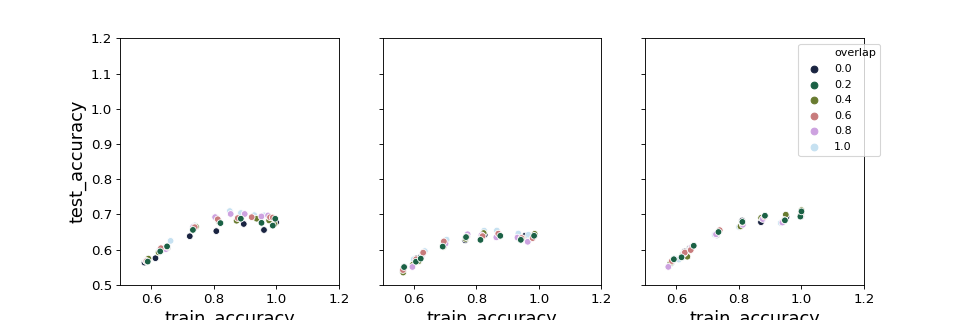

In [1126]:
overlap_palette = sns.color_palette('cubehelix', n_colors=len(overlap_thr_values))

fig, axn = pl.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

for ai, (ax, (visual_area, g)) in enumerate(zip(axn.flat, pooled.groupby(['visual_area']))):
    
    sns.scatterplot('train_accuracy', 'test_accuracy', hue='overlap', data=g, ax=ax,
                   palette=overlap_palette)
    ax.set_xlim([0.5, 1.2])
    ax.set_ylim([0.5, 1.2])
    #ax.set_aspect('equal')
    
    if ai<2:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))

<IPython.core.display.Javascript object>


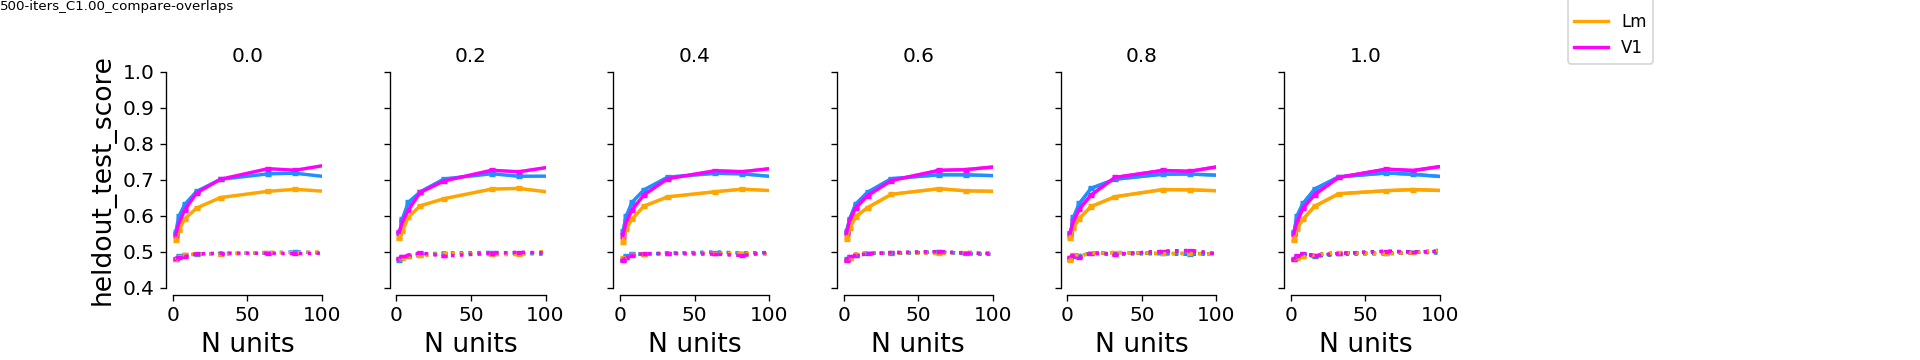

filter-repeat-fovs_heldout_test_score_0vs106_split-test-0.20_5-fold-cv_overlap0.80_C1.00_niter500__dff_resptest-nstds_respthr-10.00


In [130]:
metric = 'heldout_test_score' #'heldout_test_score'
#metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))


fig, axn = pl.subplots(1, 6, figsize=(16,3), sharex=True, sharey=True, dpi=dpi)
for ci, (overlap_l, pgroup) in enumerate(pooled.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw)
    ax.set_ylabel('')
    if ci==5:
        ax.legend(bbox_to_anchor=(1.8, 1))
    ax.set_title(overlap_l)
    ax.set_xlabel("N units")
    ax.set_ylabel('classifier accuracy')
    ax.set_xlim([0, 100])

for ci, (overlap_l, pgroup) in enumerate(pooled_chance.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    if metric=='heldout_test_score':
        ax.set_ylim([0.4, 1.0])
    if ci==0:
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel('')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.09, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   

#figname = '%s_perc_overlap_statified-folds_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
#pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [ ]:
#zoom=True

#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
#metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'

#metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
overlap_thr=0.8

res_df = pooled[pooled['overlap_thr']==overlap_thr].copy()
chance_df = pooled_chance[pooled_chance['overlap_thr']==overlap_thr].copy()

lw = 2
capsize=2

for zoom in [True, False]:
    for metric in ['heldout_aMI', 'heldout_log2MI', 'heldout_test_score']:
        metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
        
        fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
        for ai, (visual_area, g) in enumerate(res_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                    alpha=1, lw=lw,
                    label='%s' % (visual_area))
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw)
        ax.legend(bbox_to_anchor=(1., 1))
        ax.set_title(overlap_thr)
        ax.set_xlabel("N units")
        ax.set_ylabel(metric)

        for ai, (visual_area, g) in enumerate(chance_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                    alpha=1, lw=lw, linestyle=':', 
                    label=None)
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw, linestyle=':')
        if metric=='heldout_test_score':
            ax.set_ylim([0.4, 1.0])
        ax.set_ylabel(metric)

        if zoom:
            ax.set_xlim([0, 100])
            zoom_str = 'zoom_'
        else:
            zoom_str=''

        sns.despine(trim=True, offset=4)
        pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

        analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

        putils.label_figure(fig, analysis_str)

        figname = '%s_%s%s_overlap%.2f_%ivs%i_split-test-%.2f_%i-fold-cv_C%.2f_niter%i__%s' % (filter_str, zoom_str, metric, overlap_thr, m0, m100, test_split, cv_nfolds, C_value, n_iterations, response_str)
        pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

        print(decoding_dir, figname)

# Select 1 overlap_thr and do more fine-grained sampling of NCELLS

In [1141]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]


Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572


In [1142]:
print(overlap_thr, NCELLS)
n_iterations=500

(0.8, [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100])


In [1143]:
#if load_popdata:
    popdf = []
popdf_chance = []
overlap_thr=0.8
i = 0

print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]; iter_test_results=[];
        iter_results_chance=[]; iter_test_results_chance=[];
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))
            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

            # Make sure equal num trials per condition for all dsets
            # Get fewest total n trials among dsets
            fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
            # Get trial counts per cond for dset w. fewest trials
            min_ntrials = []
            keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
            for k in keys_with_few:
                currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials.append(currd.groupby(['config']).count().min().min())
            # set min N trials per condition
            min_ntrials = min(min_ntrials)

            # Get data samples for these cells
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                # Get subset of trials per cond to match min N trials
                tmp_d=[]
                for cfg, dmat in currd.groupby(['config']):
                    if dmat.shape[0] == min_ntrials:
                        tmp_d.append(dmat)
                    else:
                        tixs = np.arange(0, dmat.shape[0])
                        np.random.shuffle(tixs)
                        currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                        tmp_d.append(currd_subset)
                d_ = pd.concat(tmp_d, axis=0) 
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            curr_data = pd.concat(d_list, axis=1)
            curr_data['config'] = config_list 

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            train_data_chance=[]; test_data_chance=[]; 
            train_labels_chance=[]; test_labels_chance=[]; 
            for sz in sizes: 
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values

                # Split train/test
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            # Aggregate TRAIN/TEST data        
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)

            #### DATA - Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())

            #### DATA - Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)
            
            #### DATA - Calculate MI
            predicted_labels = trained_svc.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict.update({'heldout_test_score': test_score, 
                             'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results.append(pd.DataFrame(iterdict, index=[iteration]))
            
            # ------------------------------------------------------------------
            # Shuffle LABELS to calculate chance level
            train_labels_chance = train_labels.copy()
            np.random.shuffle(train_labels_chance)
            test_labels_chance = test_labels.copy()
            np.random.shuffle(test_labels_chance)

            #### CHANCE - Fit classifier
            svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

            # CHANCE - Test with held-out data
            trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
            test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
            
            # Chance - Calculate MI
            predicted_labels = trained_svc_chance.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                    'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area,
                          'heldout_test_sem': spstats.sem(iter_results['heldout_test_score'].values),
                          'heldout_test_std': float(iter_results['heldout_test_score'].std()),
                          'heldout_MI_sem': spstats.sem(iter_results['heldout_MI'].values),
                          'heldout_MI_std': float(iter_results['heldout_MI'].std()),
                          'heldout_aMI_sem': spstats.sem(iter_results['heldout_aMI'].values),
                          'heldout_aMI_std': float(iter_results['heldout_aMI'].std()),
                          'heldout_log2MI_sem': spstats.sem(iter_results['heldout_log2MI'].values),
                          'heldout_log2MI_std': float(iter_results['heldout_log2MI'].std())})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area,
                              'heldout_test_sem': spstats.sem(iter_results_chance['heldout_test_score'].values),
                              'heldout_test_std': float(iter_results_chance['heldout_test_score'].std()),
                              'heldout_MI_sem': spstats.sem(iter_results_chance['heldout_MI'].values),
                              'heldout_MI_std': float(iter_results_chance['heldout_MI'].std()),
                              'heldout_aMI_sem': spstats.sem(iter_results_chance['heldout_aMI'].values),
                              'heldout_aMI_std': float(iter_results_chance['heldout_aMI'].std()),
                              'heldout_log2MI_sem': spstats.sem(iter_results_chance['heldout_log2MI'].values),
                              'heldout_log2MI_std': float(iter_results_chance['heldout_log2MI'].std())})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1
results = pd.concat(popdf, axis=0)
results_chance = pd.concat(popdf_chance, axis=0)
print(results.shape, results_chance.shape)
results.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 48
... [Lm] popn size: 48
... [V1] popn size: 48
... [Li] popn size: 56
... [Lm] popn size: 56
... [V1] popn size: 56
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 72
... [Lm] popn size: 72
... [V1] popn size: 72
... [Li] popn size: 80
... [Lm] popn size: 80
... [V1] popn size: 80
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100
((33, 23), (33, 23))


,fit_time,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,heldout_log2MI_sem,heldout_log2MI_std,...,n_units,overlap,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,0.003650,0.020443,0.001229,0.027485,0.017418,0.001805,0.040362,0.029493,0.001773,0.039652,...,2,0.8,0.000512,0.561056,-4931.974762,-0.757373,0.581073,-4707.069230,-0.677117,Li
1,0.004448,0.016920,0.001019,0.022787,0.012203,0.001500,0.033538,0.024411,0.001470,0.032875,...,2,0.8,0.000518,0.545976,-5101.414273,-0.817960,0.568528,-4848.021922,-0.727540,Lm
2,0.003726,0.021042,0.001225,0.027384,0.018354,0.001798,0.040195,0.030358,0.001767,0.039507,...,2,0.8,0.000524,0.555620,-4993.058108,-0.779308,0.578534,-4735.594290,-0.687442,V1
3,0.005080,0.037578,0.001785,0.039924,0.042524,0.002622,0.058638,0.054213,0.002576,0.057598,...,4,0.8,0.000526,0.593985,-4561.980516,-0.625561,0.626014,-4202.102657,-0.497224,Li
4,0.005957,0.021228,0.001163,0.026011,0.018572,0.001708,0.038181,0.030626,0.001678,0.037526,...,4,0.8,0.000521,0.562647,-4914.093122,-0.751028,0.599295,-4502.316516,-0.604191,Lm


#### plot MI - overlap_thr fixed

<IPython.core.display.Javascript object>


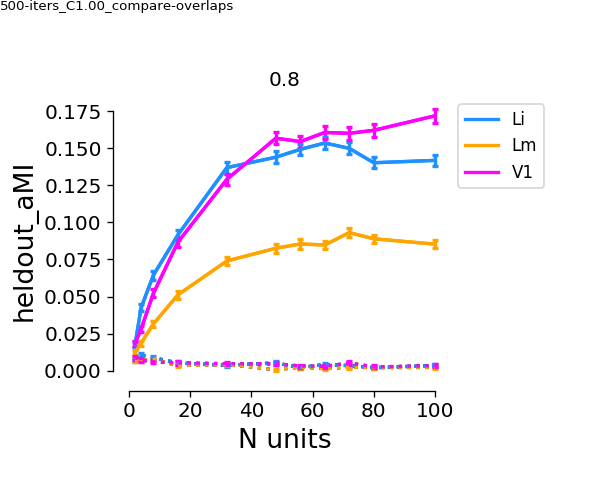

heldout_aMI_lin-sep_overlap0.80_C1.00_niter500__dff_resptest-nstds_respthr-0.05


In [1154]:
metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
figname = '%s_lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (metric, overlap_thr, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1098]:
results.head()

,fit_time,heldout_MI,heldout_MI_sem,heldout_MI_std,heldout_aMI,heldout_aMI_sem,heldout_aMI_std,heldout_log2MI,heldout_log2MI_sem,heldout_log2MI_std,...,n_units,overlap,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,visual_area
0,0.003581,0.017625,0.002604,0.018415,0.013306,0.003855,0.027258,0.025427,0.003757,0.026568,...,2,0.8,0.000538,0.570314,-4827.954641,-0.720135,0.589152,-4616.292795,-0.644598,Li
1,0.004261,0.019583,0.003882,0.027446,0.015988,0.005720,0.040450,0.028252,0.005600,0.039597,...,2,0.8,0.000520,0.549545,-5061.317730,-0.803790,0.573573,-4791.333748,-0.707420,Lm
2,0.003904,0.016860,0.003525,0.024925,0.012421,0.005144,0.036373,0.024323,0.005085,0.035960,...,2,0.8,0.000546,0.561047,-4932.073987,-0.757595,0.583879,-4675.531498,-0.666071,V1
3,0.005282,0.034933,0.005187,0.036678,0.038543,0.007593,0.053692,0.050398,0.007483,0.052915,...,4,0.8,0.000534,0.596552,-4533.147140,-0.615229,0.627538,-4184.987095,-0.491034,Li
4,0.006122,0.023208,0.003956,0.027977,0.021617,0.005797,0.040994,0.033482,0.005708,0.040362,...,4,0.8,0.000522,0.574038,-4786.113244,-0.705895,0.606195,-4424.792566,-0.576986,Lm


## Compare information metrics

<IPython.core.display.Javascript object>


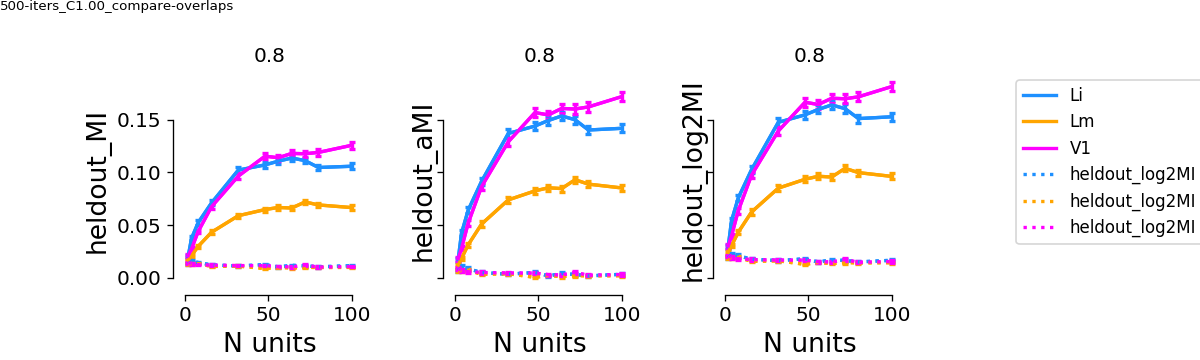

In [1155]:

lw = 2
capsize=2

fig, axn = pl.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True, dpi=dpi)

metric = 'heldout_MI'
for ax, metric in zip(axn.flat, ['heldout_MI', 'heldout_aMI', 'heldout_log2MI']):
    metric_base = 'heldout_test' if metric=='heldout_test_score' else metric
    #ax = axn[0]
    for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, lw=lw, label=None, alpha=1) #overlap_alphas[overlap_l], 
    ax.set_title(overlap_thr)
    ax.set_xlabel("N units")
    ax.set_ylabel(metric)
    
    for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, linestyle=':', label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    #ax.set_ylim([0.4, 1.0])
    ax.set_ylabel(metric)

axn[-1].legend(bbox_to_anchor=(1.6, 1))
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.15, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
# figname = 'lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (overlap_thrC_value, n_iterations, response_str)
# pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

# print(figname)

In [1102]:
results.groupby(['visual_area', 'n_units']).mean()

fit_time  heldout_MI  heldout_MI_sem  heldout_MI_std  \
visual_area n_units                                                         
Li          2        0.003581    0.017625        0.002604        0.018415   
            4        0.005282    0.034933        0.005187        0.036678   
            8        0.007254    0.044066        0.006300        0.044550   
            16       0.011590    0.083034        0.006016        0.042542   
            32       0.012882    0.105491        0.010048        0.071051   
            64       0.013936    0.116153        0.009318        0.065889   
            100      0.019367    0.115751        0.009491        0.067110   
Lm          2        0.004261    0.019583        0.003882        0.027446   
            4        0.006122    0.023208        0.003956        0.027977   
            8        0.008209    0.037167        0.005817        0.041135   
            16       0.012848    0.043340        0.005782        0.040885   
            32       0.016152    0.050928        0.005101        0.036069   
            64       0.030028    0.062859        0.005239        0.037045   
            100      0.028118    0.062521        0.007075        0.050027   
V1          2        0.003904    0.016860        0.003525        0.024925   
            4        0.005333    0.024025        0.004958        0.035058   
            8        0.007542    0.045131        0.005278        0.037323   
            16       0.012314    0.060493        0.007342        0.051913   
            32       0.014866    0.087766        0.008008        0.056628   
            64       0.023610    0.140245        0.009934        0.070245   
            100      0.017323    0.118047        0.009299        0.065755   

                     heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
visual_area n_units                                                  
Li          2           0.013306         0.003855         0.027258   
            4           0.038543         0.007593         0.053692   
            8           0.051870         0.009241         0.065340   
            16          0.108867         0.008813         0.062314   
            32          0.141849         0.014744         0.104258   
            64          0.157240         0.013708         0.096933   
            100         0.156581         0.013931         0.098509   
Lm          2           0.015988         0.005720         0.040450   
            4           0.021617         0.005797         0.040994   
            8           0.041846         0.008507         0.060156   
            16          0.051264         0.008584         0.060695   
            32          0.062215         0.007501         0.053043   
            64          0.079610         0.007660         0.054168   
            100         0.079048         0.010369         0.073323   
V1          2           0.012421         0.005144         0.036373   
            4           0.022685         0.007271         0.051414   
            8           0.053557         0.007724         0.054617   
            16          0.076196         0.010770         0.076158   
            32          0.116140         0.011715         0.082836   
            64          0.193196         0.014560         0.102956   
            100         0.160508         0.013622         0.096325   

                     heldout_log2MI  heldout_log2MI_sem  heldout_log2MI_std  \
visual_area n_units                                                           
Li          2              0.025427            0.003757            0.026568   
            4              0.050398            0.007483            0.052915   
            8              0.063574            0.009089            0.064271   
            16             0.119792            0.008680            0.061375   
            32             0.152191            0.014496            0.102505   
            64             0.167573            0.013443            0.095057   
      

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



# Test generalization

In [ ]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

In [1156]:
overlap_thr=0.8
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)


In [1230]:
from sklearn.model_selection import StratifiedKFold

In [1372]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

#NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]
NCELLS = [2, 4, 8, 16, 32, 64, 82, 100]

print(overlap_thr, NCELLS)
n_iterations=500

Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572
(0.8, [2, 4, 8, 16, 32, 64, 82, 100])


In [1373]:
#if load_popdata:
    
res_list=[]
i = 0
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))
        r_list=[]
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))

            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

            # Make sure equal num trials per condition for all dsets
            if not exact_trials:
                # Get fewest total n trials among dsets
                fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
                # Get trial counts per cond for dset w. fewest trials
                min_ntrials = []
                keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
                for k in keys_with_few:
                    currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                    min_ntrials.append(currd.groupby(['config']).count().min().min())
                # set min N trials per condition
                min_ntrials = min(min_ntrials)

            # For each cell, get is particular trials by loading the dataset it came from
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                if exact_trials:
                    tmp_d = currd.copy()
                else:
                    # get subset of trials per cond to match min N trials
                    tmp_d=[]
                    for cfg, dmat in currd.groupby(['config']):
                        if dmat.shape[0] == min_ntrials:
                            tmp_d.append(dmat)
                        else:
                            tixs = np.arange(0, dmat.shape[0])
                            np.random.shuffle(tixs)
                            currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                            tmp_d.append(currd_subset)
                    d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            #curr_data = pd.concat(d_list, axis=1)
            #curr_data['config'] = config_list 
            sample_data = pd.concat(d_list, axis=1)
            sample_labels = config_list

            #### Select train/test configs for clf A vs B
            # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            #sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #-----------------
            stimdf = sdf.copy()
            tested_sizes = sorted(sdf['size'].unique())
            tested_morphs = sorted(sdf['morphlevel'].unique())

            #% Specify train/test conditions:     
            class_name = 'morphlevel'
            class_types = [0, 106]
            restrict_transform = True
            constant_transform = 'size'

            # C = 1e3
            m0 = 0
            m100 = 106

            # Go thru all training sizes, then test on non-trained sizes
            for train_transform in tested_sizes:
                # Get train configs
                train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                        & (stimdf[constant_transform]==train_transform))].index.tolist()

                # Get corresponding indices into data array
                train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

                # Get data and labels
                X = sample_data.iloc[train_ixs].values #[train_configs]
                y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

                train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

                
                # Select generalization-test set
                untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
                test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                                       & (stimdf[class_name].isin(class_types)) )].index.tolist()
                test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
                X_test = sample_data.iloc[test_ixs].values
                y_test_labels = sample_labels[test_ixs]
                test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

                #% Train/validation split
                n_splits = 5 #len(X)
                kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
                kf.get_n_splits(train_x) #(X)

                # Do K-fold CV for current stimulus configs
                scores=[]
                test_scores = dict((tv, []) for tv in tested_sizes)
                for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):

                    # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
                    X_train, X_validate = train_x[train_index], train_x[validate_index]
                    y_train, y_validate = train_y[train_index], train_y[validate_index]
        
                    scaler = preprocessing.StandardScaler().fit(X_train)
                    X_train_transformed = scaler.transform(X_train)

                    # Fit SVM
                    trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

                    # Validate with held-out data
                    X_validate_transformed = scaler.transform(X_validate)
                    curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                    y_pred = trained_svc.predict(X_validate_transformed)

                    # Add current fold score
                    test_scores[train_transform].append(curr_score)

                    # Test (generalization) to each size and update test scores
                    for test_transform in sorted(test_transforms):
                        curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                                         if stimdf[constant_transform][tl]==test_transform]

                        X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
                        y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
                        curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
                        test_scores[test_transform].append( curr_score_test )

                test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
                test_df['iteration'] = iteration
                test_df['train_cond'] = train_transform
                r_list.append(test_df)
        iter_res = pd.concat(r_list, axis=0)
        #iter_res = res.groupby(['train_cond', 'iteration']).mean().reset_index()
        iter_res['visual_area'] = [visual_area for _ in np.arange(0, len(iter_res))]
        iter_res['n_cells'] = [curr_ncells for _ in np.arange(0, len(iter_res))]
        res_list.append(iter_res)
        

print(len(res_list))

res = pd.concat(res_list)
print(res.shape)

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 82
... [Lm] popn size: 82
... [V1] popn size: 82
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100


In [1456]:
n_iterations = 3

In [1460]:
i=0
r_list=[]
for iteration in np.arange(0, n_iterations):
    # Get random selection of NCELLS for current iter (from global ROI list)
    ncells_t = gdf.shape[0]
    curr_rids = np.array(sorted(gdf['roi'].values.copy()))

    # Random w/ replacement
    rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
    curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
    curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

    # Make sure equal num trials per condition for all dsets
    # if not exact_trials:
    # Get fewest total n trials among dsets
    fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
    # Get trial counts per cond for dset w. fewest trials
    min_ntrials = []
    keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
    for k in keys_with_few:
        currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials.append(currd.groupby(['config']).count().min().min())
    # set min N trials per condition
    min_ntrials = min(min_ntrials)

    # For each cell, get is particular trials by loading the dataset it came from
    d_list=[]
    for datakey, dgroup in curr_roidf.groupby(['datakey']):
        currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
        #if exact_trials:
        #    tmp_d = currd.copy()
        #else:
        # Get subset of trials per cond to match min N trials
        tmp_d=[]
        for cfg, dmat in currd.groupby(['config']):
            if dmat.shape[0] == min_ntrials:
                tmp_d.append(dmat)
            else:
                tixs = np.arange(0, dmat.shape[0])
                np.random.shuffle(tixs)
                currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                tmp_d.append(currd_subset)
        d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
        config_list = d_['config'].values     # Get configs on selected trials
        currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
        currd = currd.reset_index(drop=True)  # Reset trial indices 
        currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
        d_list.append(currd)
    #curr_data = pd.concat(d_list, axis=1)
    #curr_data['config'] = config_list 
    sample_data = pd.concat(d_list, axis=1)
    sample_labels = config_list

    #### Select train/test configs for clf A vs B
    # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
    #sample_data = curr_data[curr_data['config'].isin(object_configs)]

    #-----------------
    stimdf = sdf.copy()
    tested_sizes = sorted(sdf['size'].unique())
    tested_morphs = sorted(sdf['morphlevel'].unique())

    #% Specify train/test conditions:     
    class_name = 'morphlevel'
    class_types = [0, 106]
    restrict_transform = True
    constant_transform = 'size'

    # C = 1e3
    m0 = 0
    m100 = 106

    # Go thru all training sizes, then test on non-trained sizes
    for train_transform in tested_sizes:
        # Get train configs
        train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                & (stimdf[constant_transform]==train_transform))].index.tolist()

        # Get corresponding indices into data array
        train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

        # Get data and labels
        X = sample_data.iloc[train_ixs].values #[train_configs]
        y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])
        
        # Save test set for train transform
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

        # Select generalization-test set
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                               & (stimdf[class_name].isin(class_types)) )].index.tolist()
        test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
        X_test = sample_data.iloc[test_ixs].values
        y_test_labels = sample_labels[test_ixs]
        test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

        #% Train/validation split
        n_splits = 3 #len(X)
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
        kf.get_n_splits(train_x) #(X)

        test_scores = dict((tv, []) for tv in tested_sizes)
        
        # Do K-fold CV for current stimulus configs
        cv_scores=[]
        for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):
            # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
            X_train, X_validate = train_x[train_index], train_x[validate_index]
            y_train, y_validate = train_y[train_index], train_y[validate_index]

            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train_transformed = scaler.transform(X_train)

            # Fit SVM
            trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

            # Validate with held-out data
            X_validate_transformed = scaler.transform(X_validate)
            cv_score = trained_svc.score(X_validate_transformed, y_validate)  
            #y_pred = trained_svc.predict(X_validate_transformed)
            cv_scores.append(cv_score)

        # Save CV and test scores
        mean_cv_score = np.mean(cv_scores)
        
        # Train clf on all (train) data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(train_x, train_y)
        heldout_train_score = trained_svc.score(test_x, test_y)  
        
        # test_scores[train_transform].append(curr_score)

        # Test (generalization) to each size and update test scores
        for test_transform in sorted(test_transforms):
            curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                             if stimdf[constant_transform][tl]==test_transform]

            X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
            y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
            curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
            test_scores[test_transform].append( curr_score_test )


        test_scores[train_transform] = heldout_train_score
        tdf = pd.concat([pd.DataFrame({'test_cond': k, 'test_score': np.mean(v)}, index=[i]) \
                   for k, v in test_scores.items()], axis=0)
        tdf['cv_score'] = [mean_cv_score for _ in np.arange(0, len(tdf))]
        tdf['iteration'] = [iteration for _ in np.arange(0, len(tdf))]
        tdf['train_cond'] = [train_transform for _ in np.arange(0, len(tdf))]
        i+=1

        #test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
        #test_df['iteration'] = iteration
        #test_df['train_cond'] = train_transform
        r_list.append(tdf.reset_index(drop=True))

In [1461]:
print(len(r))
r = pd.concat(r_list)
print(r.shape)
r.head()

75
(75, 5)


,test_cond,test_score,cv_score,iteration,train_cond
0,40.0,0.448276,0.476389,0,10.0
1,10.0,0.833333,0.476389,0,10.0
2,20.0,0.517241,0.476389,0,10.0
3,50.0,0.517241,0.476389,0,10.0
4,30.0,0.431034,0.476389,0,10.0


In [1464]:
r.groupby(['train_cond', 'test_cond']).mean()

test_score  cv_score  iteration
train_cond test_cond                                 
10.0       10.0         0.583333  0.702579          1
           20.0         0.557471  0.702579          1
           30.0         0.419540  0.702579          1
           40.0         0.500000  0.702579          1
           50.0         0.534483  0.702579          1
20.0       10.0         0.551724  0.686177          1
           20.0         0.777778  0.686177          1
           30.0         0.839080  0.686177          1
           40.0         0.752874  0.686177          1
           50.0         0.775862  0.686177          1
30.0       10.0         0.471264  0.870370          1
           20.0         0.758621  0.870370          1
           30.0         0.944444  0.870370          1
           40.0         0.752874  0.870370          1
           50.0         0.718391  0.870370          1
40.0       10.0         0.511494  0.796759          1
           20.0         0.683908  0.796759          1
           30.0         0.804598  0.796759          1
           40.0         0.861111  0.796759          1
           50.0         0.908046  0.796759          1
50.0       10.0         0.459770  0.812500          1
           20.0         0.666667  0.812500          1
           30.0         0.793103  0.812500          1
           40.0         0.816092  0.812500          1
           50.0         0.916667  0.812500          1

In [1385]:
res.groupby(['train_cond']).count()

,10.0,20.0,30.0,40.0,50.0,iteration,visual_area,n_cells
train_cond,,,,,,,,
10.0,12000,12000,12000,12000,12000,12000,12000,12000
20.0,12000,12000,12000,12000,12000,12000,12000,12000
30.0,12000,12000,12000,12000,12000,12000,12000,12000
40.0,12000,12000,12000,12000,12000,12000,12000,12000
50.0,12000,12000,12000,12000,12000,12000,12000,12000


In [1386]:
res.groupby(['visual_area', 'train_cond', 'iteration', 'n_cells']).mean()

10.0      20.0      30.0  \
visual_area train_cond iteration n_cells                                 
Li          10.0       0         2        0.566667  0.606897  0.513793   
                                 4        0.556667  0.548276  0.610345   
                                 8        0.620000  0.644828  0.582759   
                                 16       0.593333  0.557692  0.584615   
                                 32       0.530000  0.589655  0.620690   
                                 64       0.573333  0.582759  0.510345   
                                 82       0.653333  0.615385  0.576923   
                                 100      0.623333  0.657692  0.634615   
                       1         2        0.703333  0.603448  0.693103   
                                 4        0.643333  0.520690  0.517241   
                                 8        0.673333  0.668966  0.662069   
                                 16       0.540000  0.538462  0.538462   
                                 32       0.640000  0.655172  0.658621   
                                 64       0.560000  0.592308  0.626923   
                                 82       0.520000  0.469231  0.588462   
                                 100      0.640000  0.630769  0.600000   
                       2         2        0.526667  0.562069  0.627586   
                                 4        0.606667  0.551724  0.579310   
                                 8        0.643333  0.600000  0.613793   
                                 16       0.533333  0.548276  0.572414   
                                 32       0.600000  0.565517  0.710345   
                                 64       0.580000  0.615385  0.561538   
                                 82       0.683333  0.615385  0.692308   
                                 100      0.803333  0.657692  0.573077   
                       3         2        0.650000  0.631034  0.620690   
                                 4        0.483333  0.586207  0.496552   
                                 8        0.623333  0.662069  0.603448   
                                 16       0.556667  0.557692  0.546154   
                                 32       0.640000  0.576923  0.623077   
                                 64       0.556667  0.561538  0.534615   
...                                            ...       ...       ...   
V1          50.0       496       8        0.486667  0.600000  0.666667   
                                 16       0.541379  0.610345  0.613793   
                                 32       0.496552  0.610345  0.668966   
                                 64       0.489655  0.555172  0.655172   
                                 82       0.537931  0.586207  0.624138   
                                 100      0.513793  0.527586  0.686207   
                       497       2        0.530000  0.496667  0.556667   
                                 4        0.493333  0.486667  0.680000   
                                 8        0.516667  0.530000  0.630000   
                                 16       0.562069  0.620690  0.644828   
                                 32       0.586207  0.548276  0.668966   
                                 64       0.362069  0.710345  0.796552   
                                 82       0.420690  0.565517  0.644828   
                                 100      0.479310  0.579310  0.675862   
                       498       2        0.520000  0.613333  0.683333   
                                 4        0.531034  0.448276  0.679310   
                                 8        0.558621  0.572414  0.644828   
                                 16       0.493103  0.586207  0.600000   
                                 32       0.500000  0.610345  0.675862   
                                 64       0.448276  0.682759  0.782759   
                                 82       0.531034  0.700000  0.737931   
                                 100      0.475862

In [1387]:
meandf = res.groupby(['visual_area', 'n_cells', 'train_cond']).mean().reset_index()

meandf[meandf['n_cells']==100]

,visual_area,n_cells,train_cond,10.0,20.0,30.0,40.0,50.0,iteration
35,Li,100,10.0,0.622267,0.597957,0.619528,0.578224,0.520182,249.5
36,Li,100,20.0,0.618292,0.670720,0.685196,0.652398,0.638937,249.5
37,Li,100,30.0,0.612711,0.666957,0.751507,0.740051,0.669888,249.5
38,Li,100,40.0,0.603901,0.634257,0.739493,0.768947,0.745054,249.5
39,Li,100,50.0,0.557340,0.626703,0.679067,0.737358,0.701400,249.5
75,Lm,100,10.0,0.522480,0.536097,0.556034,0.547131,0.569414,249.5
76,Lm,100,20.0,0.525862,0.569893,0.643297,0.572766,0.528366,249.5
77,Lm,100,30.0,0.537034,0.629359,0.704220,0.669138,0.644103,249.5
78,Lm,100,40.0,0.509145,0.575434,0.673779,0.707907,0.750166,249.5
79,Lm,100,50.0,0.518759,0.576069,0.627724,0.695966,0.813753,249.5


<IPython.core.display.Javascript object>


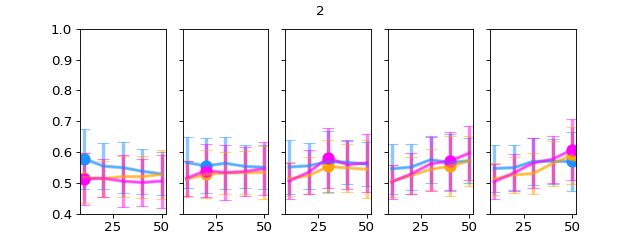

<IPython.core.display.Javascript object>


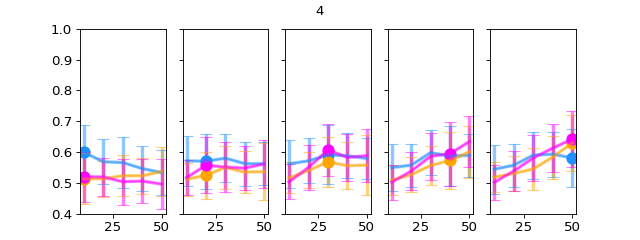

<IPython.core.display.Javascript object>


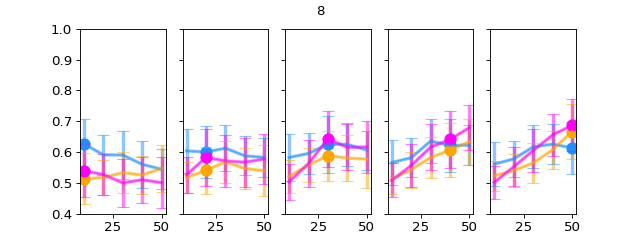

<IPython.core.display.Javascript object>


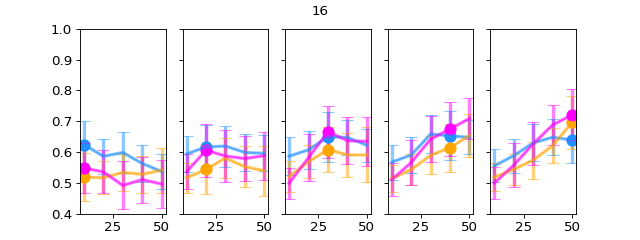

<IPython.core.display.Javascript object>


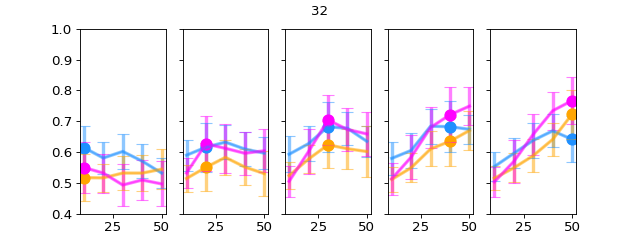

<IPython.core.display.Javascript object>


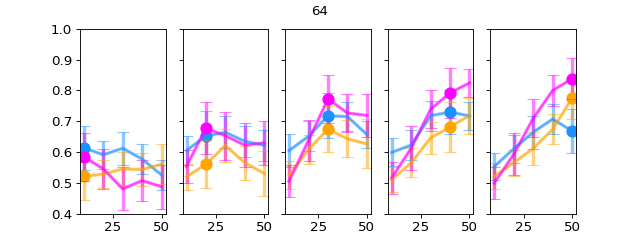

<IPython.core.display.Javascript object>


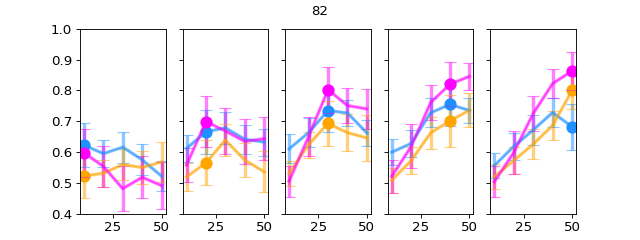

<IPython.core.display.Javascript object>


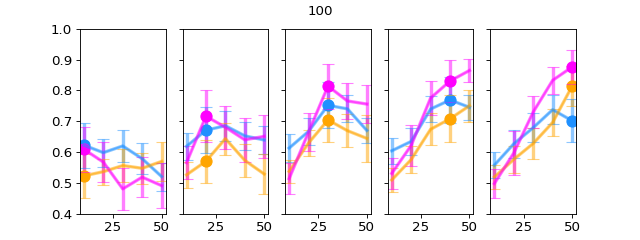

In [1424]:
for ncells in NCELLS:

    fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

In [1407]:
spstats.sem(v_df[tested_sizes])

array([ 0.00213105,  0.00313161,  0.00237023,  0.00194066,  0.00244481])

In [1422]:
fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

10.0    0.002131
20.0    0.003132
30.0    0.002370
40.0    0.001941
50.0    0.002445
dtype: float64

In [1429]:
res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean()

10.0      20.0      30.0      40.0      50.0  \
n_cells visual_area                                                     
2       Li           0.546525  0.549205  0.569532  0.569921  0.569234   
        Lm           0.512468  0.525767  0.530065  0.563154  0.589091   
        V1           0.503806  0.532294  0.564314  0.576856  0.607513   
4       Li           0.544108  0.557034  0.589919  0.592929  0.580822   
        Lm           0.518287  0.530510  0.544892  0.583309  0.629044   
        V1           0.501355  0.538276  0.580536  0.612316  0.641693   
8       Li           0.560511  0.577638  0.616656  0.625477  0.613333   
        Lm           0.522712  0.539898  0.564462  0.607050  0.666387   
        V1           0.501614  0.552315  0.604851  0.655354  0.686720   
16      Li           0.555031  0.588138  0.629946  0.647784  0.638853   
        Lm           0.518510  0.543662  0.573759  0.620745  0.696120   
        V1           0.498886  0.557640  0.626551  0.688114  0.720453   
32      Li           0.552726  0.595707  0.637820  0.668612  0.641007   
        Lm           0.514724  0.548366  0.588152  0.640848  0.723000   
        V1           0.503020  0.569164  0.657378  0.733877  0.766887   
64      Li           0.553211  0.610473  0.664343  0.706896  0.668220   
        Lm           0.520903  0.565297  0.611552  0.673848  0.775020   
        V1           0.499428  0.593021  0.709510  0.799683  0.837853   
82      Li           0.555919  0.618285  0.671734  0.728216  0.681753   
        Lm           0.519379  0.572359  0.625434  0.686593  0.799753   
        V1           0.503545  0.598600  0.725131  0.822317  0.862940   
100     Li           0.557340  0.626703  0.679067  0.737358  0.701400   
        Lm           0.518759  0.576069  0.627724  0.695966  0.813753   
        V1           0.497559  0.596938  0.729876  0.832759  0.876147   

                     iteration  train_cond  
n_cells visual_area                         
2       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
4       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
8       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
16      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
32      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
64      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
82      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
100     Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0

In [1431]:
curr_mean = res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean().reset_index()
curr_mean

,n_cells,visual_area,10.0,20.0,30.0,40.0,50.0,iteration,train_cond
0,2,Li,0.546525,0.549205,0.569532,0.569921,0.569234,249.5,50.0
1,2,Lm,0.512468,0.525767,0.530065,0.563154,0.589091,249.5,50.0
2,2,V1,0.503806,0.532294,0.564314,0.576856,0.607513,249.5,50.0
3,4,Li,0.544108,0.557034,0.589919,0.592929,0.580822,249.5,50.0
4,4,Lm,0.518287,0.530510,0.544892,0.583309,0.629044,249.5,50.0
5,4,V1,0.501355,0.538276,0.580536,0.612316,0.641693,249.5,50.0
6,8,Li,0.560511,0.577638,0.616656,0.625477,0.613333,249.5,50.0
7,8,Lm,0.522712,0.539898,0.564462,0.607050,0.666387,249.5,50.0
8,8,V1,0.501614,0.552315,0.604851,0.655354,0.686720,249.5,50.0
9,16,Li,0.555031,0.588138,0.629946,0.647784,0.638853,249.5,50.0


In [1433]:
for visual_area, v_df in curr_mean.groupby(['visual_area']):
    v_df

,n_cells,visual_area,10.0,20.0,30.0,40.0,50.0,iteration,train_cond
2,2,V1,0.503806,0.532294,0.564314,0.576856,0.607513,249.5,50.0
5,4,V1,0.501355,0.538276,0.580536,0.612316,0.641693,249.5,50.0
8,8,V1,0.501614,0.552315,0.604851,0.655354,0.686720,249.5,50.0
11,16,V1,0.498886,0.557640,0.626551,0.688114,0.720453,249.5,50.0
14,32,V1,0.503020,0.569164,0.657378,0.733877,0.766887,249.5,50.0
17,64,V1,0.499428,0.593021,0.709510,0.799683,0.837853,249.5,50.0
20,82,V1,0.503545,0.598600,0.725131,0.822317,0.862940,249.5,50.0
23,100,V1,0.497559,0.596938,0.729876,0.832759,0.876147,249.5,50.0


In [ ]:
fig, axn = pl.subplots(1,5)
sns.pointplot(x='n_cells', y=1)